# Nicholas W.: Forecasting Consensus Expectations of Nonfarm Payrolls (NFP)

## Forecasting pipeline

> **Purpose:** Produce live and back-tested **point forecasts** and **uncertainty bands** for NFP by combining individual Bloomberg forecasts with ensemble methods, then calibrate intervals off historical median-errors. This notebook is the “modeling + inference” layer that consumes the cleaned panel from Notebook 1 and builds on insights from Notebook 2.

---

### What this notebook does

- **Environment & data readiness**
  - Verifies package versions; loads `../out/nfp_df.parquet` and `../out/nfp_df_full.parquet`.

- **1. Point Forecast Ensembles**
  - **1.1 Static inverse-error:** Rolling lookbacks (3/6/12); economist weights ∝ 1/MSE or 1/MAE (plus equal-weight baseline). Out-of-sample RMSE, Diebold–Mariano, directional hit-rate, Pesaran–Timmermann.
  - **1.2 EWMA:** Time-decayed error scoring (decay 0.75–0.95) + same accuracy tests.
  - **1.3 Soft-BMA (Student-t likelihoods):** Turns recent error likelihood into weights; grid over ν and windows; full OOS evaluation.
  - **1.4 MWU (Multiplicative Weights Update):** Online expert-pool with probation/nap rules, capped simplex projection, and learning rate η-grid.
  - **Consolidation:** For each model/panel, prints **key specs** (lowest RMSE, highest hit-rate, “robust winners”), plus **live-month** signals when the latest actual is unknown.

- **1.5 “Most Accurate” economists (live)**
  - Aggregates latest **economist weights** across models; normalizes within model; blends models equally (25% each) to produce an **overall Top-10**.

- **1.6 In-sample “Robust-Ensemble” search**
  - Builds a *small* basket of strong spec-level models (from all methods), tests all combos `k ∈ {3,5}` across windows (FULL, T12, T6, T3), and reports the **Beat/Miss** live verdict and stratified diagnostics.

- **1.7 Dynamic rolling majority-vote ensembles (fully OOS)**
  - Month-by-month: form a candidate pool up to *t−1*, choose the best combos for T3/T6/T12, track rolling hit-rates, plot evolution, and benchmark against **average economist-level accuracy**.

- **2. Distributional Forecasting (prediction intervals)**
  - Rolling 24-month fit on **median forecast-errors** with:
    1) **Student-t**, 2) **GARCH(1,1)-t**, 3) **Gaussian Mixture (BIC-selected)**, 4) **BMA (Normal vs Student-t via BIC)**.  
    - Optional **crisis multiplier** widens bands when cross-sectional spread is in the top tail.  
    - Reports **empirical vs nominal coverage** and an **Accuracy × Consistency (AC) score**; prints **live CIs** when the latest actual is pending.

---

### Inputs

- Cleaned panels from Notebook 1:  
  `../out/nfp_df.parquet` (COVID-filtered) and `../out/nfp_df_full.parquet` (full history).

### Outputs & artifacts (where things live in memory)

- **Per-model evaluation tables**  
  `eval_tables[model][panel]` → DataFrame with `spec_id, obs, RMSE_smart, RMSE_median, HitRate, DM_p, PT_p, …`
- **Per-model live rows**  
  `live_tables[model][panel]` → latest `date, smart, median, pred_dir` when the month is unreleased.
- **Full out-of-sample tracks (spec-level)**  
  `oos_maps[model][panel][spec_id]` → DataFrame with `date, smart, median, actual, pred_dir`.
- **Economist weights**
  - **Live snapshot (all models/specs)**: `LIVE_WEIGHT_SNAPSHOTS` (list of dicts with `date, panel, model, spec, economist, weight`).
  - **Full monthly history**: `WEIGHT_HISTORY` (same schema + `is_live`).
  - **MWU active-weight time series**: `mwu_w_hist_maps[panel][spec_id]` → list of `(date, pd.Series(weights))`.
- **MWU pool size**  
  `pool_maps[panel][spec_id]` → `pd.Series(date → #experts)`.
- **Roll-ups**  
  `master_eval = concat(_all_eval)` and `master_live = concat(_all_live)` across all models.
- **Distributional layer**  
  `summary_records` (method, best tag, AvgAbsGap, AC_Score), `live_ci_records[method]` (pretty-printed live intervals).

> Tip: nothing is auto-saved to disk beyond what Notebook 1 exported. If you want files, export any of the above to `../out/*.parquet` or `../out/*.csv`.

---

### Quickstart

1. Run the environment & data checks at the top (will assert versions and files).
2. Execute **Section 1** to generate ensemble **point forecasts** and **live signals**.
3. Execute **Section 2** to compute **intervals** and **coverage diagnostics**.
4. (Optional) Tweak hyper-parameters (see “Knobs & toggles”) and re-run sections if interested in experimenting with hyperparameter tuning.

---

### How to explore results (snippets you can run later)

**Pick best spec & inspect OOS track**
```python
ev = eval_tables["ewma"]["Full"]
best_id = ev.loc[ev["HitRate"].idxmax(), "spec_id"]
oos = oos_maps["ewma"]["Full"][best_id]
oos.tail()
```

**Stratified diagnostics for a spec**
```python
stratified_ewma(oos_maps["ewma"]["Full"][best_id])        # EWMA
# or:
stratified_soft_bma(oos_maps["soft_bma"]["Full"][some_id])
# MWU has: stratified_mwu(oos_df)
```

**See live forecasts (when actual is NA)**
```python
live_tables["inv_err"]["Full"].tail(3)
```

**Economist influence (live month), top 20 weighted economists**
```python
snap = pd.DataFrame(LIVE_WEIGHT_SNAPSHOTS)
latest = snap[snap["date"] == snap["date"].max()]
(latest.groupby(["model","economist"])["weight"]
 .mean().groupby(level=0, group_keys=False)
 .apply(lambda s: s/s.sum()).sort_values(ascending=False).head(20))
```

**MWU weight histories**
```python
spec = list(mwu_w_hist_maps["Full"].keys())[0]
hist = mwu_w_hist_maps["Full"][spec]  # list of (date, Series)
pd.concat([ws.rename(d) for d, ws in hist], axis=1).T.tail()
```

**Distributional live intervals**
```python
print(live_ci_records.get("Student-t", "n/a"))
print(live_ci_records.get("GARCH(1,1)-t", "n/a"))
```

**Export anything you care about**
```python
pd.DataFrame(WEIGHT_HISTORY).to_parquet("../out/weights_history.parquet", index=False)
eval_tables["soft_bma"]["Full"].to_csv("../out/soft_bma_eval_full.csv", index=False)
```

---

### Knobs & toggles (common places to tweak to try to improve performance via hyperparameter tuning)

#### Point ensembles
- **Inverse-error / EWMA:** `CONT_WINDOWS = [3, 6, 12]`, `METHODS`, `DECAYS`, `RIDGE`
- **Soft-BMA:** `NU_GRID = [3, 5, 10, 25]`
- **MWU:** `ETA_GRID`, `ALPHA_NEW`, `WEIGHT_CAP`, `WEIGHT_FLOOR`, `MIN_EXPERTS`, `PROBATION_M`, `MAX_SLEEP`, `MAX_MISS_12`
- **Candidate-pool alternatives:** `RUN_TOP_HR_POOL`, `TOP_HR_N` (defines a different way to get a candidate pool via top N specs by hit rate)
- **Dynamic MV ensemble tie-breakers & averaging:** `K_SET`, `WINDOWS`, `USE_AVG_DIR`, `LAMBDA_AC`

#### Intervals
- **Rolling window & coverage levels:** `ROLL_WIN = 24`, `MIN_TRAIN = 24`, `LEVELS`
- **Crisis-adjustment:** `BETA_BASE`, `BETA_CRIS`, `PCTL_THRES`
- **GARCH scaling:** `SCALE = 100.0`
- **GMM:** `K_GRID = 1..4`, `N_SIMS = 100_000`

---

#### Notes on panels & contiguity
- Two panels are used: **Full** and **COVID-filtered**. For short windows in the COVID period, some methods fall back to **Full** history to compute weights (look-back rules are handled explicitly).
- Strict contiguity rules ensure economists in a given month had complete presence over the look-back window.

---

#### Reproducibility
- Notebook begins with pinned **version checks**. If you change environments, re-run the top cell to fail fast.
- Seeds are set where stochastic components exist (e.g., **GMM** sampling).


**Imports**

In [1]:
import os, sys, importlib
import warnings
import math
import json
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from typing import List, Tuple, Dict, Any, Optional
from scipy import stats
from scipy.optimize import brentq, minimize
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from sklearn.mixture import GaussianMixture
from collections import defaultdict
from itertools import product
from arch.univariate import ConstantMean, GARCH, StudentsT
from IPython.display import display
from pandas.tseries.offsets import MonthBegin
from packaging import version

warnings.filterwarnings("ignore")

**Environment Check**

In [3]:
# Expected versions (minimums)
REQS = {
    "python": (3, 10),  # tuple = major, minor
    "numpy": "1.26",
    "pandas": "2.1",
    "scipy": "1.11",
    "statsmodels": "0.14",
    "sklearn": "1.3",
    "matplotlib": "3.8",
    "tqdm": "4.66",
    "pyarrow": "14",
    "arch": "6.3",
}

# 1. Python version check
assert sys.version_info >= REQS["python"], \
    f"❌ Python {REQS['python'][0]}.{REQS['python'][1]}+ required, found {sys.version.split()[0]}"

# 2. Package version checks
for pkg, min_ver in list(REQS.items())[1:]:
    modname = pkg if pkg != "sklearn" else "sklearn"
    try:
        mod = importlib.import_module(modname)
    except ImportError:
        raise ImportError(f"❌ Package '{pkg}' is not installed.")
    cur_ver = getattr(mod, "__version__", "0.0")
    if version.parse(cur_ver) < version.parse(str(min_ver)):
        raise ImportError(f"❌ {pkg} >= {min_ver} required, found {cur_ver}")
    print(f"✅ {pkg:<12} {cur_ver}")
    
# 3. Data check 
DATA_DIR      = os.getenv("NFP_DATA_DIR", "../out/data")
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"

def _find_data_file(fname: str) -> str:
    candidates = [os.path.join(DATA_DIR, fname), os.path.join("../out", fname)]
    for p in candidates:
        if os.path.exists(p):
            return p
    return ""  # signal missing

# data check
missing = []
for fname in [DF_FILE, DF_FULL_FILE]:
    if not _find_data_file(fname):
        missing.append(os.path.join(DATA_DIR, fname))
if missing:
    raise FileNotFoundError(f"❌ Missing required data file(s): {missing}")
else:
    for fname in [DF_FILE, DF_FULL_FILE]:
        print(f"✅ Found data file: {_find_data_file(fname)}")

# load
df      = pd.read_parquet(_find_data_file(DF_FILE), engine="pyarrow")
df_full = pd.read_parquet(_find_data_file(DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df.head()

✅ numpy        2.2.6
✅ pandas       2.3.0
✅ scipy        1.15.3
✅ statsmodels  0.14.4
✅ sklearn      1.7.0
✅ matplotlib   3.10.3
✅ tqdm         4.67.1
✅ pyarrow      20.0.0
✅ arch         7.2.0
✅ Found data file: ../out/data\nfp_df.parquet
✅ Found data file: ../out/data\nfp_df_full.parquet
df shape     : (17046, 10)
df_full shape: (19375, 10)


,release_date,period,actual,median_forecast,economist,firm,forecast,asof,surprise,error
0,2003-06-06,2003-05-31,-17.0,-30.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,-15.0,2003-06-04,13.0,2.0
1,2003-06-06,2003-05-31,-17.0,-30.0,Alison Lynn Reaser,Point Loma Nazarene University,-15.0,2003-05-30,13.0,2.0
2,2003-06-06,2003-05-31,-17.0,-30.0,Anthony Chan,JPMorgan Chase Bank,-70.0,2003-05-30,13.0,-53.0
3,2003-06-06,2003-05-31,-17.0,-30.0,Aurelio Maccario,UniCredit Spa,-9.0,2003-05-30,13.0,8.0
4,2003-06-06,2003-05-31,-17.0,-30.0,Avery Shenfeld,Canadian Imperial Bank of Commerce,-20.0,2003-05-30,13.0,-3.0


# 1 Point Forecast Ensembles

We deploy the following methods for point and directional forecasts: 
1. **Static inverse-error**
2. **EWMA**
3. **Soft BMA with student-t likelihoods**
4. **Multiplicative weights update**
5. **Robust majority-vote ensemble**

In [3]:
# Global settings
PANELS       = {"COVID": df.copy(), "Full": df_full.copy()}
LIVE_WEIGHT_SNAPSHOTS = []                                          # one dict per (spec × live month for ensemble forecast)
WEIGHT_HISTORY = []                                                 # rows: (date, panel, model, spec, economist, weight, is_live)

# For each method we store: 
#   eval_tables[model_id][panel_name] = eval_df
#   live_tables[model_id][panel_name] = live_df
#   oos_maps   [model_id][panel_name] = oos_map

live_forecasts = []

eval_tables = defaultdict(dict)
live_tables = defaultdict(dict)
oos_maps     = defaultdict(dict)
actual_dir   = defaultdict(dict)

# flat lists for later concatenation
_all_eval = []
_all_live = []

In [4]:
# Global helpers
def _dynamic_regimes(realised: pd.DataFrame) -> dict[str, tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Helper to build dynamic regimes for stratified analysis. 
    """
    first = realised["date"].min().to_period("M").to_timestamp()
    last  = realised["date"].max()
    return {
        f"{first:%Y-%m} to 2007-12 (pre-GFC)" : (first, "2007-12-31"),
        "2008-01 to 2009-12 (GFC)"            : ("2008-01-01", "2009-12-31"),
        "2010-01-2014-12 (early-expansion)"   : ("2010-01-01", "2014-12-31"),
        "2015-01-2019-12 (late-expansion)"    : ("2015-01-01", "2019-12-31"),
        "2020-01 to 2022-12 (COVID)"          : ("2020-01-01", "2022-12-31"),
        f"2023-01 to {last.date()} (post-COVID)" :
                                               ("2023-01-01", last),
        "Trailing 24-months" : (last - pd.DateOffset(months=24) + MonthBegin(), last),
        "Trailing 12-months" : (last - pd.DateOffset(months=12) + MonthBegin(), last),
        "Trailing 6-months"  : (last - pd.DateOffset(months=6)  + MonthBegin(), last),
        "Trailing 3-months"  : (last - pd.DateOffset(months=3)  + MonthBegin(), last)
    }
    
def release_date_for(panel, rel_month):
# takes the latest row for that month. helper for ensuring sorted order for a downstream use.
    return (panel.loc[panel['rel_month'] == rel_month, 'release_date']
                    .max())

## 1.1 Static Inverse-Error Ensemble  

1. **Pick a fixed look-back window** (3, 6, or 12 releases) and keep only economists who supplied forecasts in every month of that window.  
2. **Score each economist’s past accuracy** with either MSE, MAE, or (for comparison) give everyone the same score.  
3. **Turn scores into weights** – weight ∝ 1 / (error + tiny ridge) – then normalise so all weights sum to 1.  
4. **Form the “smart” point forecast** as the weighted average of the individual forecasts; the Bloomberg median is the naïve benchmark.  
5. **Evaluate rolling out-of-sample**: RMSE vs. median, Diebold-Mariano p-value, directional hit-rate, and Pesaran-Timmermann p-value.  


In [5]:
# ---------------------------------------------------------------
#  INVERSE‑ERROR ENSEMBLE 
# ---------------------------------------------------------------

CONT_WINDOWS = [3, 6, 12]                                           # look‑back windows for applicable methods
METHODS      = ["inverse_mse", "inverse_mae", "equal_weight"]       # inverse error ensemble and EWMA
RIDGE        = 1e-6                                                 # for numerical stability, not regularization 

def weight_vector(history: pd.DataFrame, economists: pd.Index, method: str) -> pd.Series:
    """Return inverse‑error (MSE / MAE) or equal weights."""
    if method == "equal_weight":
        w = pd.Series(1.0, index=economists)
    else:
        grp   = history[history["economist"].isin(economists)] \
                     .groupby("economist")["error"]
        score = grp.apply(lambda s: np.nanmean(s**2) if method == "inverse_mse"
                          else np.nanmean(np.abs(s)))
        w = 1.0 / (score + RIDGE)
    return w / w.sum()

# -------------------- BACKTEST ---------------------------------
def backtest_panel(panel: pd.DataFrame, label: str, full_df:Optional[pd.DataFrame] = None):
    """
    Walk‑forward evaluation over (window, method). Returns: eval_df, live_df, oos_map (keyed by spec_id).
    """
        # work at month-level to ensure consistent lookback behavior
    panel = panel.copy()
    panel["rel_month"] = panel["release_date"].dt.to_period("M")     # YYYY-MM

    if full_df is not None:                                          # COVID fallback
        full_df = full_df.copy()
        full_df["rel_month"] = full_df["release_date"].dt.to_period("M")

    months  = np.sort(panel["rel_month"].unique())                   # all months
    eval_r, live_r, oos_map = [], [], {}

    for window, method in tqdm(product(CONT_WINDOWS, METHODS),
                               total=len(CONT_WINDOWS)*len(METHODS),
                               desc=f"{label} grid"):
        spec_id = f"inv_err_w{window}_m{method}"
        recs    = []

        # walk‑forward
        for idx in range(window, len(months)):
            t_mon = months[idx]
            start_mon = t_mon - window 
            hist = panel[(panel["rel_month"] < t_mon) &
                 (panel["rel_month"] >= start_mon)]
            
            if label == "COVID" and hist["rel_month"].nunique() < window:
                if full_df is None:
                    raise ValueError("full_df must be provided for COVID back-test")
                hist = full_df[(full_df["rel_month"] <  t_mon) &
                            (full_df["rel_month"] >= start_mon)]
            
            # keep economists that have a forecast this month only (no ghosts)
            cur        = panel[panel["rel_month"] == t_mon]
            cur_econs  = cur["economist"].dropna().unique()
            hist       = hist[hist["economist"].isin(cur_econs)]
       
            econs = (
                hist.groupby("economist")["forecast"]
                .apply(lambda s: len(s) == window and s.notna().all())  # strict contiguity check
                .pipe(lambda s: s[s].index)
                )
            if econs.empty:
                continue

            w = weight_vector(hist, econs, method)

            cur = panel[(panel["rel_month"] == t_mon) &
                        (panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()

            smart   = np.dot(w, f_t.loc[w.index])
            median  = panel.loc[panel["rel_month"] == t_mon, "median_forecast"].iloc[0]
            actual  = panel.loc[panel["rel_month"] == t_mon, "actual"].iloc[0]
            preddir = int(smart > median)
            real_d  = release_date_for(panel, t_mon)
            
            # record monthly weights (historical)
            if isinstance(w, pd.Series) and not w.empty:
                WEIGHT_HISTORY.extend({
                    "date":   real_d,
                    "panel":  label,
                    "model":  "inv_err",
                    "spec":   spec_id,
                    "economist": econ,
                    "weight": float(wt),
                    "is_live": bool(pd.isna(actual)),
                } for econ, wt in w.items())
            recs.append((real_d, smart, median, actual, preddir))

        if not recs:
            continue

        # out‑of‑sample frame
        oos = pd.DataFrame(recs,
                           columns=["date", "smart", "median", "actual", "pred_dir"])
        oos_map[spec_id] = oos

        # live row if latest actual is still NA
        if pd.isna(oos.iloc[-1, 3]):
            last = oos.iloc[-1]
            live_r.append({
                "spec_id": spec_id,
                "panel":   label,
                "window":  window,
                "method":  method,
                "date":    last["date"],
                "smart":   last["smart"],
                "median":  last["median"],
                "pred_dir":last["pred_dir"]
            })
            
            snap = {
            "date"  : last["date"],
            "panel" : label,              
            "model" : "inv_err",          # hardcode per method
            "spec"  : spec_id,
            # economist-level payload (snapshot per economist so we can aggregate weights later)
            }
            for econ, wt in w.items():        # w:weight vector we just used
                LIVE_WEIGHT_SNAPSHOTS.append(
                    {**snap,
                    "economist" : econ,
                    "weight"    : float(wt)}  # keep raw decimal for now
                )   
            
        # realized evaluation
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:
            continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

        obs      = len(eval_df)
        rmse_s   = np.sqrt((eval_df["smart_err"]**2).mean())
        rmse_m   = np.sqrt((eval_df["median_err"]**2).mean())
        diff     = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits     = (eval_df["pred_dir"] == eval_df["actual_dir"]).sum()
        hit_rate = hits / obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_p     = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                             np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_r.append({
            "spec_id":     spec_id,
            "panel":       label,
            "window":      window,
            "method":      method,
            "obs":         obs,
            "RMSE_smart":  rmse_s,
            "RMSE_median": rmse_m,
            "SmartBetter": int(rmse_s < rmse_m),
            "HitRate":     hit_rate,
            "Binom_p":     binom_p,
            "PT_p":        pt_p,
            "DM_p":        dm_p
        })

    eval_df = pd.DataFrame(eval_r)
    live_df = pd.DataFrame(live_r)
    eval_df["model_id"] = "inv_err"
    live_df["model_id"] = "inv_err"
    return eval_df, live_df, oos_map

# =================== DRIVER =========================
for name, pnl in PANELS.items():
    ev, lv, om = backtest_panel(pnl, name, full_df=df_full)
    eval_tables["inv_err"][name] = ev
    live_tables["inv_err"][name] = lv
    oos_maps    ["inv_err"][name] = om
    _all_eval.append(ev)
    _all_live.append(lv)

    if om:
        realised = next(iter(om.values())).dropna(subset=["actual"])
        actual_dir["inv_err"][name] = (realised["actual"] > realised["median"]).astype(int).values
    else:
        actual_dir["inv_err"][name] = np.array([], dtype=int)

pd.set_option("display.float_format", "{:.3f}".format)

def print_key_specs(eval_df: pd.DataFrame, panel_name: str) -> None:
    low_rmse = eval_df.loc[eval_df["RMSE_smart"].idxmin()]
    high_hit = eval_df.loc[eval_df["HitRate"].idxmax()]
    robust = eval_df[(eval_df["DM_p"] < .10) & (eval_df["PT_p"] < .10)]
    if not robust.empty:
        r = robust.loc[robust["RMSE_smart"].idxmin()]
        rob_str = f"{r['spec_id']} (w={int(r['window'])}, m={r['method']})"
    else:
        rob_str = "None (DM_p & PT_p ≥ 0.10)"

    print(f"\n{panel_name} panel key specs:")
    print(f"  • Lowest RMSE    : {low_rmse['spec_id']} (w={int(low_rmse['window'])}, m={low_rmse['method']})")
    print(f"  • Highest HitRate: {high_hit['spec_id']} (w={int(high_hit['window'])}, m={high_hit['method']})")
    print(f"  • Robust Winner  : {rob_str}")

# back‑test tables and key specs
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["inv_err"]["COVID"].to_string(index=False))
print_key_specs(eval_tables["inv_err"]["COVID"], "COVID")

print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["inv_err"]["Full"].to_string(index=False))
print_key_specs(eval_tables["inv_err"]["Full"], "Full")

# stratified diagnostics on best‑HitRate spec 
best = eval_tables["inv_err"]["Full"].loc[
    eval_tables["inv_err"]["Full"]["HitRate"].idxmax(), "spec_id"]
oos_best = oos_maps["inv_err"]["Full"][best]

def stratified_diagnostics(oos: pd.DataFrame) -> pd.DataFrame:
    """
    Stratified evaluation for the inverse-error ensemble, using the
    dynamic-anchor regime map introduced in MWU.
    """
    realised = oos.dropna(subset=["actual"]).copy()
    if realised.empty:
        return pd.DataFrame()

    # add error & direction fields
    realised["smart_err"]  = realised["smart"]  - realised["actual"]
    realised["median_err"] = realised["median"] - realised["actual"]
    realised["pred_dir"]   = (realised["smart"]  > realised["median"]).astype(int)
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)

    dyn_regimes = _dynamic_regimes(realised)
    rows = []
    for lbl, (start, end) in dyn_regimes.items():
        sub = realised[(realised["date"] >= pd.Timestamp(start)) &
                       (realised["date"] <= pd.Timestamp(end))]
        if sub.empty:
            continue
        n   = len(sub)
        hr  = (sub["pred_dir"] == sub["actual_dir"]).mean()
        diff= sub["smart_err"]**2 - sub["median_err"]**2
        dm_p= (1.0 if diff.std(ddof=1) == 0 else
               2 * (1 - stats.norm.cdf(abs(diff.mean() /
                                            diff.std(ddof=1) * np.sqrt(n)))))
        rows.append({
            "Regime":      lbl,
            "Obs":         n,
            "RMSE_smart":  np.sqrt((sub["smart_err"]**2).mean()),
            "RMSE_median": np.sqrt((sub["median_err"]**2).mean()),
            "SmartBetter": int(((sub["smart_err"]**2).mean()
                                <  (sub["median_err"]**2).mean())),
            "HitRate":     hr,
            "DM_p":        dm_p
        })

    return pd.DataFrame(rows)

print(f"\n=== Stratified diagnostics (FULL • best spec {best}) ===")
tbl = stratified_diagnostics(oos_best)
print("No realised data." if tbl.empty else tbl.to_string(index=False))

print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel in ["COVID","Full"]:
    lv = live_tables["inv_err"][panel]
    if lv.empty: continue
    ev = eval_tables["inv_err"][panel]
    # choose specs
    sel = {
      "Lowest RMSE":     ev.loc[ev["RMSE_smart"].idxmin()],
      "Highest HitRate": ev.loc[ev["HitRate"].idxmax()]
    }
    rob = ev[(ev["DM_p"]<.10)&(ev["PT_p"]<.10)]
    if not rob.empty:
        sel["Robust Winner"] = rob.loc[rob["RMSE_smart"].idxmin()]
    # merge labels & print
    lm, info = defaultdict(set), {}
    for lbl,row in sel.items():
        lm[row["spec_id"]].add(lbl); info[row["spec_id"]]=row
    for sid, labels in lm.items():
        row = lv[lv["spec_id"]==sid].iloc[-1]
        txt = " & ".join(sorted(labels))
        sig = "Beat" if row["pred_dir"] else "Miss"
        print(f"--- {panel} • {txt} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {sig}  ({sid})\n")

COVID grid:   0%|          | 0/9 [00:00<?, ?it/s]

Full grid:   0%|          | 0/9 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
                  spec_id panel  window       method  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p model_id
  inv_err_w3_minverse_mse COVID       3  inverse_mse  227      72.256       73.173            1    0.529    0.426 0.372 0.139  inv_err
  inv_err_w3_minverse_mae COVID       3  inverse_mae  227      72.238       73.173            1    0.533    0.353 0.313 0.036  inv_err
 inv_err_w3_mequal_weight COVID       3 equal_weight  227      72.316       73.173            1    0.555    0.111 0.095 0.008  inv_err
  inv_err_w6_minverse_mse COVID       6  inverse_mse  224      71.746       72.955            1    0.571    0.038 0.029 0.020  inv_err
  inv_err_w6_minverse_mae COVID       6  inverse_mae  224      71.865       72.955            1    0.558    0.095 0.075 0.013  inv_err
 inv_err_w6_mequal_weight COVID       6 equal_weight  224      71.951       72.955            1    0.580    0.019 0.015 0.013  inv_err
 inv_err_w12_m

## 1.2 Exponentially-Weighted Moving-Average Ensemble (EWMA)  
1. **Choose a look-back window & decay**  
   * Window = 3, 6, or 12 releases; decay ∈ {0.75…0.95}.  
   * Newer months get more influence: weight ∝ decay^(age).  
2. **Score each economist’s recent errors** (MSE, MAE, or skip scoring for equal-weight baseline).  
3. **Turn scores into economist weights** – inverse-error ⇢ larger weight for lower error; normalise to 1.  
4. **Combine current forecasts** with those weights to form the “smart” EWMA forecast.  
5. **Roll forward month-by-month** to track RMSE, directional hit-rate, Diebold-Mariano & Pesaran-Timmermann p-values.  

In [6]:
# ----------------------------------------------------------------
# EWMA
# ----------------------------------------------------------------
CONT_WINDOWS = [3, 6, 12]                                           # look-back windows 
METHODS      = ["inverse_mse", "inverse_mae", "equal_weight"]       
RIDGE        = 1e-6                                                 # for numerical stability, not regularization
DECAYS       = np.arange(0.75, 1.00, 0.10)                          # decays for EWMA

def ewma_time_weights(window: int, decay: float) -> np.ndarray:
    """Exponentially-decaying (oldest → newest) weights that sum to 1."""
    w = decay ** np.arange(window - 1, -1, -1, dtype=float)
    return w / w.sum()

# -------------------- BACKTEST ---------------------------------
def backtest_ewma(panel: pd.DataFrame,
                  windows=CONT_WINDOWS,
                  decays=DECAYS,
                  methods=METHODS,
                  ridge: float = RIDGE,
                  *,
                  full_df: Optional[pd.DataFrame] = None):
    """
    Walk-forward grid search over (window, decay, method). Returns: eval_df,
    live_df, oos_map (keyed by spec_id).
    """
    # work at month-level
    panel_name = getattr(panel, "name", None)   # "COVID", "Full", or None
    panel = panel.copy()
    panel.name = panel_name 
    panel["rel_month"] = panel["release_date"].dt.to_period("M")

    if full_df is not None:                            # COVID fallback panel
        full_df = full_df.copy()
        full_df["rel_month"] = full_df["release_date"].dt.to_period("M")

    pname   = getattr(panel, "name", "panel")
    months  = np.sort(panel["rel_month"].unique())     # unique months ASC
    eval_r, live_r, oos_map = [], [], {}

    for window, decay, method in tqdm(
            product(windows, decays, methods),
            total=len(windows) * len(decays) * len(methods),
            desc=f"{pname} grid"):
        spec_id = f"ewma_w{window}_d{decay:.2f}_m{method}"
        recs    = []

        # -------------------- walk-forward ----------------------------
        for idx in range(window, len(months)):
            w_last   = None
            t_mon    = months[idx]                     # current target month
            start_mon = t_mon - window                 # inclusive look-back anchor

            # history slice (same panel)
            hist = panel[(panel["rel_month"] < t_mon) &
                         (panel["rel_month"] >= start_mon)]

            # COVID fallback to full history if slice too short
            if panel_name == "COVID" and hist["rel_month"].nunique() < window:
                if full_df is None:
                    raise ValueError("full_df must be provided for COVID back-test")
                hist = full_df[(full_df["rel_month"] < t_mon) &
                                (full_df["rel_month"] >= start_mon)]

            # keep only economists active this month
            cur       = panel[panel["rel_month"] == t_mon]
            cur_econs = cur["economist"].dropna().unique()
            hist      = hist[hist["economist"].isin(cur_econs)]

            # strict W-month contiguity per economist
            econs = (hist.groupby("economist")["forecast"]
                           .apply(lambda s: len(s) == window and s.notna().all())
                           .pipe(lambda s: s[s].index))
            if econs.empty:
                continue

            # ---------- economist weights ----------
            if method == "equal_weight":
                w_econ = pd.Series(1.0, index=econs)
            else:
                t_w     = ewma_time_weights(window, decay)
                scores  = {}
                for e in econs:
                    errs = (hist.loc[hist["economist"] == e]
                                .sort_values("rel_month")["error"]
                                .values)
                    scores[e] = np.sum(t_w * (errs**2 if method == "inverse_mse"
                                              else np.abs(errs)))
                w_econ = pd.Series({e: 1.0 / (s + ridge) for e, s in scores.items()})
            w_econ /= w_econ.sum()

            # ---------- current-month forecasts ----------
            cur = (panel[(panel["rel_month"] == t_mon) &
                         (panel["economist"].isin(w_econ.index))]
                   .sort_values("release_date")          # deterministic
                   .groupby("economist", as_index=False) # one row per econ
                   .last())                              # latest submission

            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w_econ.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()
            w_last = w.copy()

            smart   = float(np.dot(w, f_t.loc[w.index]))
            median  = float(panel.loc[panel["rel_month"] == t_mon,
                                      "median_forecast"].iloc[0])
            actual  = float(panel.loc[panel["rel_month"] == t_mon,
                                      "actual"].iloc[0])
            preddir = int(smart > median)
            real_d  = release_date_for(panel, t_mon)
            
            # record monthly weights (historical)
            if isinstance(w, pd.Series) and not w.empty:
                WEIGHT_HISTORY.extend({
                    "date":   real_d,
                    "panel":  pname,
                    "model":  "ewma",
                    "spec":   spec_id,
                    "economist": econ,
                    "weight": float(wt),
                    "is_live": bool(pd.isna(actual)),
                } for econ, wt in w.items())

            
            recs.append((real_d, smart, median, actual, preddir))

        if not recs:
            continue

        # store out-of-sample frame
        oos_map[spec_id] = pd.DataFrame(
            recs, columns=["date", "smart", "median", "actual", "pred_dir"])

        # ---------- live row ----------
        oos = oos_map[spec_id]
        if pd.isna(oos.iloc[-1, 3]):                 # last actual is NaN
            last = oos.iloc[-1]
            live_r.append({
                "spec_id": spec_id, "panel": pname,
                "window": window, "decay": decay, "method": method,
                "date":   last["date"], "smart": last["smart"],
                "median": last["median"], "pred_dir": last["pred_dir"]
            })

            # economist weight snapshot
            if w_last is not None:
                snap_meta = {
                    "date": last["date"], "panel": pname,
                    "model": "ewma", "spec": spec_id
                }
                for econ, wt in w_last.items():
                    LIVE_WEIGHT_SNAPSHOTS.append(
                        {**snap_meta, "economist": econ, "weight": float(wt)}
                    )

        # ---------- realized evaluation ----------
        df_eval = oos.dropna(subset=["actual"]).copy()
        if df_eval.empty:
            continue

        df_eval["smart_err"]  = df_eval["smart"]  - df_eval["actual"]
        df_eval["median_err"] = df_eval["median"] - df_eval["actual"]
        df_eval["actual_dir"] = (df_eval["actual"] > df_eval["median"]).astype(int)

        obs      = len(df_eval)
        rmse_s   = np.sqrt((df_eval["smart_err"]**2).mean())
        rmse_m   = np.sqrt((df_eval["median_err"]**2).mean())
        diff     = df_eval["smart_err"]**2 - df_eval["median_err"]**2
        dm_p     = 2 * (1 - stats.norm.cdf(abs(diff.mean() /
                                               diff.std(ddof=1) * np.sqrt(obs))))
        hits     = (df_eval["pred_dir"] == df_eval["actual_dir"]).sum()
        hit_rate = hits / obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = df_eval["pred_dir"].mean(), df_eval["actual_dir"].mean()
        c_joint  = (df_eval["pred_dir"] & df_eval["actual_dir"]).mean()
        pt_p     = 2 * (1 - stats.norm.cdf(abs((c_joint - p1 * p2) /
                                              np.sqrt(p1 * p2 * (1 - p1) * (1 - p2) / obs))))

        eval_r.append({
            "spec_id": spec_id, "panel": pname,
            "window": window, "decay": decay, "method": method,
            "obs": obs, "RMSE_smart": rmse_s, "RMSE_median": rmse_m,
            "SmartBetter": int(rmse_s < rmse_m), "HitRate": hit_rate,
            "Binom_p": binom_p, "PT_p": pt_p, "DM_p": dm_p
        })

    eval_df = pd.DataFrame(eval_r)
    live_df = pd.DataFrame(live_r)
    eval_df["model_id"] = "ewma"
    live_df["model_id"] = "ewma"
    return eval_df, live_df, oos_map


def stratified_ewma(oos: pd.DataFrame) -> pd.DataFrame:
    """
    Dynamic-regime stratified diagnostics for any EWMA spec.
    """
    realised = oos.dropna(subset=["actual"]).copy()
    if realised.empty:
        return pd.DataFrame()

    # pre-compute error & direction columns
    realised["smart_err"]  = realised["smart"]  - realised["actual"]
    realised["median_err"] = realised["median"] - realised["actual"]
    realised["pred_dir"]   = (realised["smart"]  > realised["median"]).astype(int)
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)

    dyn_regimes = _dynamic_regimes(realised)  

    rows = []
    for lbl, (start, end) in dyn_regimes.items():
        sub = realised[(realised["date"] >= pd.Timestamp(start)) &
                       (realised["date"] <= pd.Timestamp(end))]
        if sub.empty:
            continue
        n   = len(sub)
        hr  = (sub["pred_dir"] == sub["actual_dir"]).mean()
        diff= sub["smart_err"]**2 - sub["median_err"]**2
        dm_p= (1.0 if diff.std(ddof=1) == 0 else
               2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(n)))))
        rows.append({
            "Regime":      lbl,
            "Obs":         n,
            "RMSE_smart":  np.sqrt((sub["smart_err"]**2).mean()),
            "RMSE_median": np.sqrt((sub["median_err"]**2).mean()),
            "SmartBetter": int(((sub["smart_err"]**2).mean()
                                <  (sub["median_err"]**2).mean())),
            "HitRate":     hr,
            "DM_p":        dm_p
        })
    return pd.DataFrame(rows)


# =================== DRIVER =========================
for name, pnl in PANELS.items():
    pnl.name = name
    ev, lv, om = backtest_ewma(pnl, full_df=df_full)
    eval_tables["ewma"][name] = ev
    live_tables["ewma"][name] = lv
    oos_maps    ["ewma"][name] = om
    _all_eval.append(ev)
    _all_live.append(lv)

    if om:
        realised = next(iter(om.values())).dropna(subset=["actual"])
        actual_dir["ewma"][name] = (realised["actual"] > realised["median"]).astype(int).values
    else:
        actual_dir["ewma"][name] = np.array([], dtype=int)

# formatting & key‑spec function
pd.set_option("display.float_format", "{:.3f}".format)
def print_key_specs_ewma(df: pd.DataFrame, panel_name: str):
    low = df.loc[df["RMSE_smart"].idxmin()]
    high= df.loc[df["HitRate"].idxmax()]
    rob = df[(df["DM_p"]<.10)&(df["PT_p"]<.10)]
    if not rob.empty:
        r = rob.loc[rob["RMSE_smart"].idxmin()]
        rob_str = f"{r['spec_id']} (w={int(r['window'])}, d={r['decay']:.2f}, m={r['method']})"
    else:
        rob_str = "None (DM_p & PT_p ≥ 0.10)"
    print(f"\n{panel_name} panel key specs:")
    print(f"  • Lowest RMSE    : {low['spec_id']} (w={int(low['window'])}, d={low['decay']:.2f}, m={low['method']})")
    print(f"  • Highest HitRate: {high['spec_id']} (w={int(high['window'])}, d={high['decay']:.2f}, m={high['method']})")
    print(f"  • Robust Winner  : {rob_str}")

# print back‑test tables + key specs
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["ewma"]["COVID"].to_string(index=False))
print_key_specs_ewma(eval_tables["ewma"]["COVID"], "COVID")

print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["ewma"]["Full"].to_string(index=False))
print_key_specs_ewma(eval_tables["ewma"]["Full"], "Full")

# stratified diagnostics for best HR spec
best = eval_tables["ewma"]["Full"].loc[
    eval_tables["ewma"]["Full"]["HitRate"].idxmax(),"spec_id"
]
oos_best = oos_maps["ewma"]["Full"][best]

print(f"\n=== Stratified diagnostics (FULL • best spec {best}) ===")
tbl = stratified_ewma(oos_best)
print("No realised data." if tbl.empty else tbl.to_string(index=False))

print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel in ["COVID","Full"]:
    lv = live_tables["ewma"][panel]
    if lv.empty: continue
    ev = eval_tables["ewma"][panel]
    sel = {
      "Lowest RMSE":     ev.loc[ev["RMSE_smart"].idxmin()],
      "Highest HitRate": ev.loc[ev["HitRate"].idxmax()]
    }
    rob = ev[(ev["DM_p"]<.10)&(ev["PT_p"]<.10)]
    if not rob.empty:
        sel["Robust Winner"] = rob.loc[rob["RMSE_smart"].idxmin()]
    from collections import defaultdict
    lm, info = defaultdict(set), {}
    for lbl,row in sel.items():
        lm[row["spec_id"]].add(lbl); info[row["spec_id"]] = row
    for sid, labels in lm.items():
        row = lv[lv["spec_id"]==sid].iloc[-1]
        txt = " & ".join(sorted(labels))
        sig = "Beat" if row["pred_dir"] else "Miss"
        print(f"--- {panel} • {txt} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {sig}  ({sid})\n")

COVID grid:   0%|          | 0/27 [00:00<?, ?it/s]

Full grid:   0%|          | 0/27 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
                     spec_id panel  window  decay       method  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p model_id
  ewma_w3_d0.75_minverse_mse COVID       3  0.750  inverse_mse  227      72.218       73.173            1    0.542    0.232 0.199 0.126     ewma
  ewma_w3_d0.75_minverse_mae COVID       3  0.750  inverse_mae  227      72.213       73.173            1    0.533    0.353 0.311 0.035     ewma
 ewma_w3_d0.75_mequal_weight COVID       3  0.750 equal_weight  227      72.316       73.173            1    0.555    0.111 0.095 0.008     ewma
  ewma_w3_d0.85_minverse_mse COVID       3  0.850  inverse_mse  227      72.236       73.173            1    0.537    0.288 0.246 0.132     ewma
  ewma_w3_d0.85_minverse_mae COVID       3  0.850  inverse_mae  227      72.225       73.173            1    0.529    0.426 0.377 0.035     ewma
 ewma_w3_d0.85_mequal_weight COVID       3  0.850 equal_weight  227      72.316       73.

## 1.3 Soft Bayesian Model Averaging (Soft-BMA)  
1. **Collect each economist’s last *W* errors** (window = 3, 6, 12 releases).  
2. **Compute a Student-t likelihood for every economist**  
   * Fix degrees-of-freedom ν (tried grid: 3, 5, 10, 25).  
   * Plug-in scale = RMS error; assume zero-mean.  
   * Likelihood ∝ ∏ t<sub>ν</sub>(error<sub>t</sub> | 0, σ).  
3. **Convert likelihoods to weights**  
   * Weight<sub>i</sub> ∝ exp(log-likelihood<sub>i</sub>);  
     normalize so all weights sum to 1.  
4. **Form the “smart” forecast** as the weighted average of current-month forecasts.  
5. **Walk forward month-by-month**, evaluating RMSE, directional hit-rate, Diebold-Mariano, and Pesaran-Timmermann tests for every (window, ν) combination.


In [7]:
# ------------------------------------------------------------
# Soft-BMA  (month-wise look-back fix applied)
# ------------------------------------------------------------
CONT_WINDOWS = [3, 6, 12]                                  # look-back windows
NU_GRID      = [3, 5, 10, 25]                                  # Student-t d.o.f grid

def soft_bma_weights(err_dict: dict[str, np.ndarray], nu: int) -> pd.Series:
    """
    Return per-economist weights proportional to their Student-t likelihood over past errors.
    """
    log_like = {}
    for econ, errs in err_dict.items():
        if errs.size == 0:
            continue
        sigma = np.sqrt((errs**2).mean())                   # plug-in scale
        if sigma < 1e-8:                                   # guard against blow-ups
            continue
        log_like[econ] = student_t.logpdf(errs, df=nu, loc=0.0, scale=sigma).sum()

    if not log_like:                                       # all invalid
        return pd.Series(dtype=float)

    w = pd.Series(np.exp(list(log_like.values())), index=log_like.keys())
    return w / w.sum()

# -------------------- BACKTEST --------------------
def backtest_soft_bma(
    panel: pd.DataFrame,
    windows: list[int] = CONT_WINDOWS,
    nus: list[int]     = NU_GRID,
    *,
    full_df: Optional[pd.DataFrame] = None
):
    """
    Walk-forward grid search over (window, nu) using **month-wise** logic.
    All release-date irregularities are normalised via a Period['M'] column
    (`rel_month`).  Returns: eval_df, live_df, oos_map (keyed by spec_id).
    """
    # work at month-level
    panel_name = getattr(panel, "name", "panel")           # save .name
    panel = panel.copy()
    panel.name = panel_name                                # restore after copy
    panel["rel_month"] = panel["release_date"].dt.to_period("M")

    if full_df is not None:
        full_df = full_df.copy()
        full_df["rel_month"] = full_df["release_date"].dt.to_period("M")

    months = np.sort(panel["rel_month"].unique())          # ascending months
    eval_rows, live_rows, oos_map = [], [], {}

    for W, nu in tqdm(product(windows, nus),
                      total=len(windows)*len(nus),
                      desc=f"{panel_name} grid"):
        spec_id = f"soft_bma_w{W}_nu{nu}"
        recs, w_last = [], None

        # -------------- walk-forward ------------------------
        for idx in range(W, len(months)):
            w_last  = None
            t_mon   = months[idx]                          # target month
            start_m = t_mon - W                           # inclusive anchor

            hist = panel[(panel["rel_month"] <  t_mon) &
                         (panel["rel_month"] >= start_m)]

            # COVID fallback
            if panel_name == "COVID" and hist["rel_month"].nunique() < W:
                if full_df is None:
                    raise ValueError("full_df must be provided for COVID back-test")
                hist = full_df[(full_df["rel_month"] <  t_mon) &
                                (full_df["rel_month"] >= start_m)]

            # keep only economists active this month
            cur        = panel[panel["rel_month"] == t_mon]
            cur_econs  = cur["economist"].dropna().unique()
            hist       = hist[hist["economist"].isin(cur_econs)]

            # strict W-month contiguity
            econs = (hist.groupby("economist")["forecast"]
                           .apply(lambda s: len(s) == W and s.notna().all())
                           .pipe(lambda s: s[s].index))
            if econs.empty:
                continue

            # error history (already sorted by month)
            err_dict = {
                e: (hist.loc[hist["economist"] == e]
                        .sort_values("rel_month")["error"].values)
                for e in econs
            }

            w_econ = soft_bma_weights(err_dict, nu)
            if w_econ.empty:
                continue

            # align with current forecasts (dedupe same-day submissions)
            cur = (panel[(panel["rel_month"] == t_mon) &
                         (panel["economist"].isin(w_econ.index))]
                   .sort_values("release_date")
                   .groupby("economist", as_index=False)
                   .last())

            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w_econ.reindex(f_t.index).dropna()
            if w.empty:
                continue
            w /= w.sum()
            w_last = w.copy()

            smart  = float(np.dot(w, f_t.loc[w.index]))
            median = float(panel.loc[panel["rel_month"] == t_mon,
                                     "median_forecast"].iloc[0])
            actual = float(panel.loc[panel["rel_month"] == t_mon,
                                     "actual"].iloc[0])
            pred_d = int(smart > median)
            real_d  = release_date_for(panel, t_mon)
            
            # record monthly weights (historical)
            if isinstance(w, pd.Series) and not w.empty:
                WEIGHT_HISTORY.extend({
                    "date":   real_d,
                    "panel":  panel_name,
                    "model":  "soft_bma",
                    "spec":   spec_id,
                    "economist": econ,
                    "weight": float(wt),
                    "is_live": bool(pd.isna(actual)),
                } for econ, wt in w.items())

            
            recs.append((real_d, smart, median, actual, pred_d))

        # ---------------- collect results -------------------
        if not recs:
            continue

        oos = pd.DataFrame(recs,
                           columns=["date","smart","median","actual","pred_dir"])
        oos_map[spec_id] = oos

        # live row + snapshot
        last = oos.iloc[-1]
        if pd.isna(last["actual"]):
            live_rows.append({
                "spec_id": spec_id, "panel": panel_name,
                "window":  W,       "nu":    nu,
                "date":    last["date"],
                "smart":   last["smart"],
                "median":  last["median"],
                "pred_dir": last["pred_dir"]
            })
            if w_last is not None:
                snap_meta = {
                    "date":  last["date"],
                    "panel": panel_name,
                    "model": "soft_bma",
                    "spec":  spec_id
                }
                for econ, wt in w_last.items():
                    LIVE_WEIGHT_SNAPSHOTS.append(
                        {**snap_meta, "economist": econ, "weight": float(wt)}
                    )

        # realised evaluation
        df_eval = oos.dropna(subset=["actual"]).copy()
        if df_eval.empty:
            continue
        df_eval["smart_err"]  = df_eval["smart"]  - df_eval["actual"]
        df_eval["median_err"] = df_eval["median"] - df_eval["actual"]
        df_eval["pred_dir"]   = (df_eval["smart"]  > df_eval["median"]).astype(int)
        df_eval["actual_dir"] = (df_eval["actual"] > df_eval["median"]).astype(int)

        obs      = len(df_eval)
        rmse_s   = np.sqrt((df_eval["smart_err"]**2).mean())
        rmse_m   = np.sqrt((df_eval["median_err"]**2).mean())
        diff     = df_eval["smart_err"]**2 - df_eval["median_err"]**2
        dm_p     = 2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
        hits     = (df_eval["pred_dir"] == df_eval["actual_dir"]).sum()
        hr       = hits/obs
        binom_p  = stats.binomtest(hits, obs, .5).pvalue
        p1, p2   = df_eval["pred_dir"].mean(), df_eval["actual_dir"].mean()
        c_joint  = (df_eval["pred_dir"] & df_eval["actual_dir"]).mean()
        pt_p     = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                             np.sqrt(p1*p2*(1-p1)*(1-p2)/obs))))

        eval_rows.append({
            "spec_id": spec_id, "panel": panel_name,
            "window":  W,      "nu":    nu,
            "obs":          obs,
            "RMSE_smart":   rmse_s,
            "RMSE_median":  rmse_m,
            "SmartBetter":  int(rmse_s < rmse_m),
            "HitRate":      hr,
            "Binom_p":      binom_p,
            "PT_p":         pt_p,
            "DM_p":         dm_p
        })

    eval_df = pd.DataFrame(eval_rows)
    live_df = pd.DataFrame(live_rows)
    eval_df["model_id"] = "soft_bma"
    live_df["model_id"] = "soft_bma"
    return eval_df, live_df, oos_map


def stratified_soft_bma(oos: pd.DataFrame) -> pd.DataFrame:
    """
    Stratified diagnostics for a Soft-BMA spec.
    """
    realised = oos.dropna(subset=["actual"]).copy()
    if realised.empty:
        return pd.DataFrame()

    # pre-compute error & direction columns
    realised["smart_err"]  = realised["smart"]  - realised["actual"]
    realised["median_err"] = realised["median"] - realised["actual"]
    realised["pred_dir"]   = (realised["smart"]  > realised["median"]).astype(int)
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)

    dyn_regimes = _dynamic_regimes(realised)  

    rows = []
    for lbl, (start, end) in dyn_regimes.items():
        sub = realised[(realised["date"] >= pd.Timestamp(start)) &
                       (realised["date"] <= pd.Timestamp(end))]
        if sub.empty:
            continue
        n   = len(sub)
        hr  = (sub["pred_dir"] == sub["actual_dir"]).mean()
        diff= sub["smart_err"]**2 - sub["median_err"]**2
        dm_p= (1.0 if diff.std(ddof=1) == 0 else
               2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(n)))))
        rows.append({
            "Regime":      lbl,
            "Obs":         n,
            "RMSE_smart":  np.sqrt((sub["smart_err"]**2).mean()),
            "RMSE_median": np.sqrt((sub["median_err"]**2).mean()),
            "SmartBetter": int(((sub["smart_err"]**2).mean()
                                <  (sub["median_err"]**2).mean())),
            "HitRate":     hr,
            "Binom_p":     stats.binomtest((sub["pred_dir"]==sub["actual_dir"]).sum(), n, .5).pvalue,
            "PT_p":        stats.binomtest((sub["pred_dir"]&sub["actual_dir"]).sum(), n, .25).pvalue,
            "DM_p":        dm_p
        })
    return pd.DataFrame(rows)


# ------------------------ DRIVER -------------------------------
for name, pnl in PANELS.items():
    pnl.name = name
    ev, lv, om = backtest_soft_bma(pnl, full_df=df_full)
    eval_tables["soft_bma"][name] = ev
    live_tables["soft_bma"][name] = lv
    oos_maps   ["soft_bma"][name] = om

    _all_eval.append(ev)
    _all_live.append(lv)

    if om:
        realised = next(iter(om.values())).dropna(subset=["actual"])
        actual_dir["soft_bma"][name] = (
            (realised["actual"] > realised["median"])
            .astype(int)
            .values
        )
    else:
        actual_dir["soft_bma"][name] = np.array([], dtype=int)

# ---- formatting & key‑spec summary ----
pd.set_option("display.float_format", "{:.3f}".format)
def print_key_specs_soft(df: pd.DataFrame, panel_name: str) -> None:
    low  = df.loc[df["RMSE_smart"].idxmin()]
    high = df.loc[df["HitRate"].idxmax()]
    rob  = df[(df["DM_p"] < .10) & (df["PT_p"] < .10)]
    if not rob.empty:
        r = rob.loc[rob["RMSE_smart"].idxmin()]
        rob_str = f"{r['spec_id']} (w={int(r['window'])}, nu={int(r['nu'])})"
    else:
        rob_str = "None (DM_p & PT_p ≥ 0.10)"

    print(f"\n{panel_name} panel key specs:")
    print(f"  • Lowest RMSE    : {low['spec_id']} (w={int(low['window'])}, nu={int(low['nu'])})")
    print(f"  • Highest HitRate: {high['spec_id']} (w={int(high['window'])}, nu={int(high['nu'])})")
    print(f"  • Robust Winner  : {rob_str}")

# ---- back‑test tables + key specs ----
print("\n=== Back‑test summary (COVID panel) ===")
print(eval_tables["soft_bma"]["COVID"].to_string(index=False))
print_key_specs_soft(eval_tables["soft_bma"]["COVID"], "COVID")

print("\n=== Back‑test summary (Full panel) ===")
print(eval_tables["soft_bma"]["Full"].to_string(index=False))
print_key_specs_soft(eval_tables["soft_bma"]["Full"], "Full")

# ---- stratified diagnostics on best HR spec (FULL panel) ----
best_spec = eval_tables["soft_bma"]["Full"].loc[
    eval_tables["soft_bma"]["Full"]["HitRate"].idxmax(), "spec_id"
]
print(f"\n=== Stratified diagnostics (FULL • best spec {best_spec}) ===")
st_tbl = stratified_soft_bma(oos_maps["soft_bma"]["Full"][best_spec])
print("No realised data." if st_tbl.empty else st_tbl.to_string(index=False))

print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
for panel in ["COVID", "Full"]:
    lv = live_tables["soft_bma"][panel]
    if lv.empty:
        continue
    ev = eval_tables["soft_bma"][panel]

    # pick specs by criterion
    sel = {
        "Lowest RMSE":     ev.loc[ev["RMSE_smart"].idxmin()],
        "Highest HitRate": ev.loc[ev["HitRate"].idxmax()]
    }
    rob = ev[(ev["DM_p"] < .10) & (ev["PT_p"] < .10)]
    if not rob.empty:
        sel["Robust Winner"] = rob.loc[rob["RMSE_smart"].idxmin()]

    # consolidate output
    label_map, info = defaultdict(set), {}
    for lbl, row in sel.items():
        label_map[row["spec_id"]].add(lbl)
        info[row["spec_id"]] = row

    for sid, labels in label_map.items():
        row = lv[lv["spec_id"] == sid].iloc[-1]
        txt = " & ".join(sorted(labels))
        sig = "Beat" if row["pred_dir"] else "Miss"

        print(f"--- {panel} • {txt} ---")
        print(f"Date   : {row['date'].date()}")
        print(f"Smart  : {row['smart']:.1f} k")
        print(f"Median : {row['median']:.1f} k")
        print(f"Signal : {sig}  ({sid})\n")

COVID grid:   0%|          | 0/12 [00:00<?, ?it/s]

Full grid:   0%|          | 0/12 [00:00<?, ?it/s]


=== Back‑test summary (COVID panel) ===
          spec_id panel  window  nu  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p model_id
  soft_bma_w3_nu3 COVID       3   3  227      72.549       73.173            1    0.520    0.596 0.538 0.449 soft_bma
  soft_bma_w3_nu5 COVID       3   5  227      72.556       73.173            1    0.533    0.353 0.308 0.455 soft_bma
 soft_bma_w3_nu10 COVID       3  10  227      72.563       73.173            1    0.533    0.353 0.308 0.461 soft_bma
 soft_bma_w3_nu25 COVID       3  25  227      72.569       73.173            1    0.524    0.507 0.449 0.466 soft_bma
  soft_bma_w6_nu3 COVID       6   3  224      71.667       72.955            1    0.558    0.095 0.076 0.185 soft_bma
  soft_bma_w6_nu5 COVID       6   5  224      71.663       72.955            1    0.562    0.071 0.057 0.185 soft_bma
 soft_bma_w6_nu10 COVID       6  10  224      71.664       72.955            1    0.562    0.071 0.057 0.186 soft_bma
 soft_bma_w6_nu

## 1.4 Multiplicative Weights Update (MWU)

1. **Expert Pool Management**  
   * Entry: A forecaster joins only after **12 consecutive submissions** (probation).  
   * Activity: May miss up to **2 consecutive months** without penalty; longer gaps set weight to zero.  
   * Drop Rule: Missing **>6 months** in any rolling 12-month window leads to permanent removal.  

2. **Initial Weighting on Entry**  
   * Newcomers share a fixed **α = 10%** of total weight (never below floor).  
   * Incumbents keep the remainder, scaled proportionally.  
   * All weights are projected onto a capped simplex (**cap = 50%**, **floor = 0.1%**) so they sum to 1.  

3. **Forecast Formation**  
   * Smart forecast = Σ(weight × latest forecast) for **active experts** this month (must have ≥10).  
   * Weights used are **active** post-projection shares, not global pool weights.  

4. **Weight Update After Realisation**  
   * Lossₑ = (forecastₑ − actual)² + ε, with ε = 1e-6.  
   * Weightₑ ← Weightₑ × exp(−η × Lossₑ), where **η ∈ {0.001, 0.003, …, 0.019}**.  
   * Apply cap/floor and renormalise to unity after every update.  

5. **Persistence**  
   * Weights evolve continuously over the full sample — no regime resets.  
   * Returning experts within the sleep limit retain their prior weight.  


COVID grid:   0%|          | 0/10 [00:00<?, ?it/s]

Full grid:   0%|          | 0/10 [00:00<?, ?it/s]


=== Back-test summary (COVID panel) ===
     spec_id   eta  obs  RMSE_smart  RMSE_median  SmartBetter  HitRate  Binom_p  PT_p  DM_p
mwu_eta0.001 0.001  218      70.524       70.913            1    0.505    0.946 0.482 0.324
mwu_eta0.003 0.003  218      70.492       70.913            1    0.509    0.839 0.482 0.274
mwu_eta0.005 0.005  218      70.493       70.913            1    0.523    0.542 0.390 0.269
mwu_eta0.007 0.007  218      70.502       70.913            1    0.523    0.542 0.390 0.273
mwu_eta0.009 0.009  218      70.510       70.913            1    0.518    0.636 0.390 0.279
mwu_eta0.011 0.011  218      70.516       70.913            1    0.518    0.636 0.390 0.284
mwu_eta0.013 0.013  218      70.521       70.913            1    0.523    0.542 0.310 0.288
mwu_eta0.015 0.015  218      70.525       70.913            1    0.523    0.542 0.310 0.291
mwu_eta0.017 0.017  218      70.528       70.913            1    0.523    0.542 0.310 0.294
mwu_eta0.019 0.019  218      70.531    

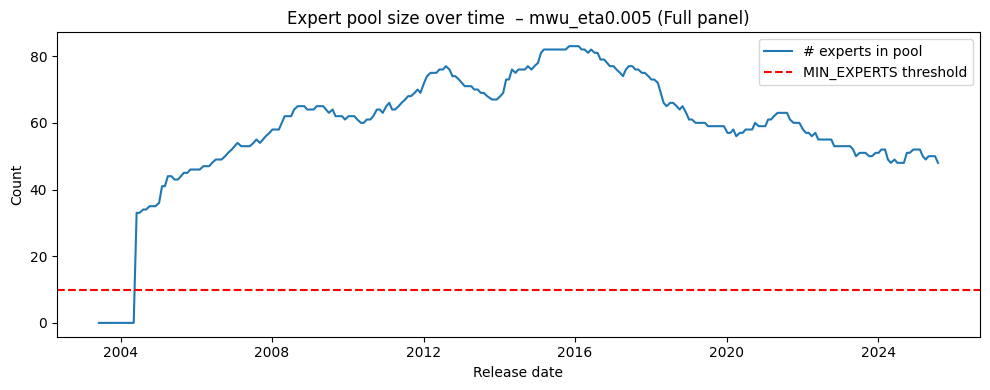

In [8]:
# ======================================================================
#  Multiplicative Weights Update (MWU)
# ======================================================================

ETA_GRID     = np.arange(0.001, 0.021, 0.002)   # learning-rate grid
ALPHA_NEW    = 0.10                             # newcomer share
WEIGHT_CAP   = 0.50                             # max weight / expert
WEIGHT_FLOOR = 1e-3                             # min weight / expert
MIN_EXPERTS  = 10                               # need this many experts to issue a smart forecast
PROBATION_M  = 12                               # consecutive submissions to enter
MAX_SLEEP    = 2                                # allowed consecutive misses
MAX_MISS_12  = 6                                # max misses in rolling 12M before drop
RIDGE        = 1e-6                             # tiny for MWU loss

# ---------- scratch containers for MWU ----------
mwu_eval_tbls, mwu_live_tbls, mwu_oos_tbls = {}, {}, {}
# keep full weight history per spec to plot
mwu_w_hist_maps = {}  # panel -> spec_id -> list[(date, pd.Series(weights))]

def project_capped_simplex(w: dict[str, float], cap: float, floor: float,
                           tol: float = 1e-12, max_iter: int = 200) -> dict[str, float]:
    """
    Project weights y onto { x : sum x = 1, floor <= x_i <= cap }.
    """
    if not w:
        return {}
    keys = list(w.keys())
    y = np.array([float(w[k]) for k in keys], dtype=float)

    n = y.size
    # Feasibility check: 1 must lie in [n*floor, n*cap]
    lo_sum, hi_sum = n * floor, n * cap
    if 1.0 < lo_sum - 1e-15 or 1.0 > hi_sum + 1e-15:
        # Infeasible box; fall back to uniform within the box
        x = np.full(n, 1.0 / n, dtype=float)
        x = np.clip(x, floor, cap)
        x /= x.sum()
        return {k: float(v) for k, v in zip(keys, x)}

    # Bracketing for tau
    tau_lo = np.min(y - cap)
    tau_hi = np.max(y - floor)

    for _ in range(max_iter):
        tau = 0.5 * (tau_lo + tau_hi)
        x = np.clip(y - tau, floor, cap)
        s = x.sum()
        if abs(s - 1.0) <= tol:
            break
        if s > 1.0:
            # need to shrink → increase tau
            tau_lo = tau
        else:
            # need to expand → decrease tau
            tau_hi = tau

    x = np.clip(y - 0.5 * (tau_lo + tau_hi), floor, cap)
    # tiny numeric fix without breaking bounds
    if not np.isclose(x.sum(), 1.0, atol=1e-12):
        r = 1.0 - x.sum()
        free = (x > floor + 1e-15) & (x < cap - 1e-15)
        if free.any():
            x[free] += r / free.sum()
            x = np.clip(x, floor, cap)
    return {k: float(v) for k, v in zip(keys, x)}



def mwu_long(df: pd.DataFrame, eta: float, *, full_df: Optional[pd.DataFrame] = None):
    """
    Core MWU engine for a single η.

    Returns
    -------
    (oos_df, weight_history, pool_size_series)
      • oos_df           : DataFrame[date, smart, median, actual, pred_dir]
      • weight_history   : list[(date, pd.Series(weights))] — ACTIVE portfolio (post-projection)
      • pool_size_series : pd.Series mapping date -> #experts in global pool (after drops)
    """
    panel_name = getattr(df, "name", None)      # "COVID", "Full", or None
    is_covid   = (panel_name == "COVID")

    # Timeline
    dates = np.sort(df["release_date"].unique())

    df = df.sort_values(["release_date", "asof"]).copy()
    df.name = panel_name

    # Rolling 12-month submission history (per economist)
    sub_hist = defaultdict(lambda: np.zeros(12, dtype=int))

    # Global pool weights and sleep counters
    w, sleep = {}, {}

    # Outputs
    rows, w_hist, pool = [], [], []

    for d in dates:
        if d in df["release_date"].values:
            cur = (df[df["release_date"] == d]
                   .sort_values("asof")
                   .groupby("economist", as_index=False)
                   .last())
        else:
            cur = pd.DataFrame(columns=["economist","forecast","median_forecast","actual","asof"])

        cur_econs = cur["economist"].tolist()

        # Probation check BEFORE logging this month's submission
        ready_entrants = [e for e in cur_econs if e not in w and sub_hist[e].sum() == PROBATION_M]

        # Update submission histories
        for e in cur_econs:
            sub_hist[e] = np.roll(sub_hist[e], -1); sub_hist[e][-1] = 1
        for e in sub_hist.keys() - set(cur_econs):
            sub_hist[e] = np.roll(sub_hist[e], -1); sub_hist[e][-1] = 0

        # Entrants: allocate newcomer share and shrink incumbents
        if ready_entrants:
            share_each = max(ALPHA_NEW / len(ready_entrants), WEIGHT_FLOOR)
            inc_scale  = max(0.0, 1.0 - share_each * len(ready_entrants))
            for e in w:
                w[e] *= inc_scale
            for e in ready_entrants:
                w[e] = share_each
                sleep[e] = 0

        has_data = not cur.empty

        # Sleep bookkeeping & permanent drops
        if has_data:
            for e in list(w):
                if e in cur_econs:
                    sleep[e] = 0
                else:
                    sleep[e] += 1
                # drop if missed > MAX_MISS_12 in rolling 12M
                if sub_hist[e].sum() < PROBATION_M - MAX_MISS_12:
                    w.pop(e, None); sleep.pop(e, None)

        # Project global pool to capped simplex BEFORE using it
        if w:
            w = project_capped_simplex(w, cap=WEIGHT_CAP, floor=WEIGHT_FLOOR)

        # Available experts this month (respect sleeper rule)
        is_covid_year = pd.Timestamp(d).year in (2020, 2021, 2022)
        in_gap = (panel_name == "Full") and is_covid_year
        avail = [e for e in w if (e in cur_econs and sleep[e] <= MAX_SLEEP)]

        # Out-of-sample record & snapshot (ACTIVE weights AFTER projection)
        if not in_gap and len(avail) >= MIN_EXPERTS:
            f_t = cur.set_index("economist")["forecast"].reindex(avail)

            # ACTIVE portfolio must also obey cap
            w_avail = {e: w[e] for e in avail}
            w_avail = project_capped_simplex(w_avail, cap=WEIGHT_CAP, floor=WEIGHT_FLOOR)
            w_vec = pd.Series(w_avail)

            smart  = float((w_vec * f_t).sum())
            median = float(cur["median_forecast"].iloc[0])
            actual = float(cur["actual"].iloc[0])
            rows.append((pd.Timestamp(d), smart, median, actual, int(smart > median)))
            
                        # ACTIVE portfolio weights
            w_avail = {e: w[e] for e in avail}
            w_avail = project_capped_simplex(w_avail, cap=WEIGHT_CAP, floor=WEIGHT_FLOOR)
            ws = pd.Series(w_avail, dtype=float)
            assert np.isclose(float(ws.sum()), 1.0, atol=1e-9), f"MWU snapshot not normalized (sum={ws.sum():.6f})"
            w_hist.append((pd.Timestamp(d), ws.copy()))

        # MWU update (upon realization)
        if has_data and pd.notna(cur["actual"].iloc[0]) and avail:
            y = float(cur["actual"].iloc[0])
            loss = (cur.set_index("economist")["forecast"] - y).pow(2) + RIDGE
            for e in avail:
                w[e] *= math.exp(-eta * float(loss.loc[e]))

        # Re-project after update to keep invariants
        if w:
            w = project_capped_simplex(w, cap=WEIGHT_CAP, floor=WEIGHT_FLOOR)

        pool.append((pd.Timestamp(d), len(w)))

    oos = pd.DataFrame(rows, columns=["date","smart","median","actual","pred_dir"])
    pool_sz = pd.Series(dict(pool)).sort_index()
    return oos, w_hist, pool_sz



# ---------- stratified_mwu ------------------------------------
def stratified_mwu(oos_df: pd.DataFrame) -> pd.DataFrame:
    """
    Runs the stratified procedure for MWU. Probation and continuity honor hidden (covid) months.
    """
    realised = oos_df.dropna(subset=["actual"]).copy()
    if realised.empty:
        return pd.DataFrame()

    # error & direction columns ---------------------------------------
    realised["smart_err"]  = realised["smart"]  - realised["actual"]
    realised["median_err"] = realised["median"] - realised["actual"]
    realised["pred_dir"]   = (realised["smart"] > realised["median"]).astype(int)
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)


    dyn_regimes = _dynamic_regimes(realised)
    
    # compute stats ----------------------------------------------------
    rows = []
    for lbl, (start, end) in dyn_regimes.items():
        sub = realised[(realised["date"] >= pd.Timestamp(start)) &
                       (realised["date"] <= pd.Timestamp(end))]
        if sub.empty:
            continue
        n   = len(sub)
        hr  = (sub["pred_dir"] == sub["actual_dir"]).mean()
        diff= sub["smart_err"]**2 - sub["median_err"]**2
        dm_p= (1.0 if diff.std(ddof=1)==0 else
               2*(1 - st.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*math.sqrt(n)))))
        rows.append({
            "Regime":      lbl, "Obs": n,
            "RMSE_smart":  math.sqrt((sub["smart_err"]**2).mean()),
            "RMSE_median": math.sqrt((sub["median_err"]**2).mean()),
            "SmartBetter": int(((sub["smart_err"]**2).mean()
                                <  (sub["median_err"]**2).mean())),
            "HitRate":     hr,
            "Binom_p":     st.binomtest(
                               (sub["pred_dir"] == sub["actual_dir"]).sum(), n, .5
                           ).pvalue,
            "PT_p":        st.binomtest(
                               (sub["pred_dir"] & sub["actual_dir"]).sum(), n, .25
                           ).pvalue,
            "DM_p":        dm_p
        })
    return pd.DataFrame(rows)

# ---------- helper: eval from OOS ----------
def eval_from_oos(oos: pd.DataFrame, eta: float):
    realised = oos.dropna(subset=["actual"]).copy()
    if realised.empty:
        return None
    realised["smart_err"]  = realised["smart"]  - realised["actual"]
    realised["median_err"] = realised["median"] - realised["actual"]
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)
    diff = realised["smart_err"]**2 - realised["median_err"]**2
    dm_p = (1.0 if diff.std(ddof=1)==0 else
            2*(1 - st.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*math.sqrt(len(realised))))))
    return {
        "eta":         eta,
        "obs":         len(realised),
        "RMSE_smart":  math.sqrt((realised["smart_err"]**2).mean()),
        "RMSE_median": math.sqrt((realised["median_err"]**2).mean()),
        "SmartBetter": int(((realised["smart_err"]**2).mean()
                            <  (realised["median_err"]**2).mean())),
        "HitRate":     (realised["pred_dir"] == realised["actual_dir"]).mean(),
        "Binom_p":     st.binomtest((realised["pred_dir"]==realised["actual_dir"]).sum(),
                                    len(realised), .5).pvalue,
        "PT_p":        st.binomtest((realised["pred_dir"]&realised["actual_dir"]).sum(),
                                    len(realised), .25).pvalue,
        "DM_p":        dm_p
    }

def label_specs(tbl: pd.DataFrame):
    out = defaultdict(set)
    if tbl.empty:
        return out
    out[tbl.loc[tbl["RMSE_smart"].idxmin(),"spec_id"]].add("Lowest RMSE")
    out[tbl.loc[tbl["HitRate"].idxmax(),"spec_id"]].add("Highest HitRate")
    rob = tbl[(tbl["SmartBetter"]==1)&(tbl["DM_p"]<.10)&(tbl["PT_p"]<.10)]
    if not rob.empty:
        out[rob.loc[rob["RMSE_smart"].idxmin(),"spec_id"]].add("Robust Winner")
    return out

def print_backtests():
    for name in ["COVID", "Full"]:
        tbl = mwu_eval_tbls.get(name, pd.DataFrame())
        print(f"\n=== Back-test summary ({name} panel) ===")
        if tbl.empty:
            print("No realised observations."); continue
        cols = ["spec_id","eta","obs","RMSE_smart","RMSE_median",
                "SmartBetter","HitRate","Binom_p","PT_p","DM_p"]
        print(tbl[cols].to_string(index=False))
        for sp, lbs in label_specs(tbl).items():
            print(f"  • {' & '.join(sorted(lbs))}: {sp}")
        if not any("Robust Winner" in labs for labs in label_specs(tbl).values()):
            print("  • Robust Winner  : None (DM_p & PT_p ≥ 0.10)")

def print_stratified():
    tbl = mwu_eval_tbls.get("Full", pd.DataFrame())
    if tbl.empty:
        return
    best = tbl.loc[tbl["HitRate"].idxmax(), "spec_id"]
    print(f"\n=== Stratified diagnostics (FULL • best spec {best}) ===")
    print(stratified_mwu(mwu_oos_tbls["Full"][best]).to_string(index=False))

def print_live():
    combined = {}
    for p, tbl in mwu_eval_tbls.items():
        for sp, lbs in label_specs(tbl).items():
            combined.setdefault((p, sp), set()).update(lbs)
    if not combined:
        return
    print("\n================ CONSOLIDATED LIVE FORECASTS ================\n")
    for (p, sp), lbs in combined.items():
        lv = mwu_live_tbls[p]
        if sp not in lv["spec_id"].values:
            continue
        r = lv[lv["spec_id"] == sp].iloc[-1]
        verdict = "Beat" if r["pred_dir"] else "Miss"
        print(f"--- {p} • {' & '.join(sorted(lbs))} ---")
        print(f"Date   : {r['date'].date()}")
        print(f"Smart  : {r['smart']:.1f} k")
        print(f"Median : {r['median']:.1f} k")
        print(f"Signal : {verdict}  ({sp})\n")

# ---------- run grid & append to global ----------
pool_maps = {}  # panel ➜ spec_id ➜ pd.Series(pool_size)
for panel_name, pnl in PANELS.items():      # PANELS is global (COVID & Full)
    pnl = pnl.copy(); pnl.name = panel_name
    eval_rows, live_rows, oos_map, pool_map = [], [], {}, {}

    for eta in tqdm(ETA_GRID, desc=f"{panel_name} grid"):
        spec_id = f"mwu_eta{eta:.3f}"
        oos, w_hist, pool_sz = mwu_long(pnl, eta, full_df = df_full if panel_name == "COVID" else None)
        
        # append MWU’s full monthly weight history to the shared store
        if mwu_w_hist_maps.get(panel_name, {}).get(spec_id):  # optional guard
            pass  # already captured in mwu_w_hist_maps; below writes a flat table too

        # use the w_hist returned for this eta/spec (ACTIVE weights when a forecast was formed)
        if w_hist:
            # map date -> is_live for this spec
            oos_for_spec = oos  # from mwu_long
            live_map = {pd.Timestamp(r.date): bool(pd.isna(r.actual)) for r in oos_for_spec.itertuples()}

            for d, w_s in w_hist:
                if not isinstance(w_s, pd.Series) or w_s.empty:
                    continue
                is_live = live_map.get(pd.Timestamp(d), False)
                WEIGHT_HISTORY.extend({
                    "date":   pd.Timestamp(d),
                    "panel":  panel_name,
                    "model":  "mwu",
                    "spec":   spec_id,
                    "economist": econ,
                    "weight": float(wt),
                    "is_live": is_live,
                } for econ, wt in w_s.items())

        
        pool_map[spec_id] = pool_sz
        oos_map[spec_id]  = oos
        
        mwu_w_hist_maps.setdefault(panel_name, {})[spec_id] = w_hist


        ev = eval_from_oos(oos, eta)
        if ev:
            ev.update({"spec_id": spec_id, "panel": panel_name})
            eval_rows.append(ev)

        if not oos.empty and pd.isna(oos.iloc[-1, 3]):  # live month
            last = oos.iloc[-1]
            live_rows.append({
                "spec_id": spec_id, "panel": panel_name,
                "date":    last["date"], "smart": last["smart"],
                "median":  last["median"], "pred_dir": last["pred_dir"]
            })
            
            live_dt = last["date"]
            w_last  = next((w for d, w in reversed(w_hist) if d == live_dt), None)
            if w_last is not None and not w_last.empty:
                # Sanity check: ACTIVE weights should obey cap already
                if float(w_last.max()) > WEIGHT_CAP + 1e-9:
                    print(f"[WARN] Cap exceeded in snapshot for {spec_id} on {live_dt}: {float(w_last.max()):.4f} > {WEIGHT_CAP}")

                meta = {
                    "date" :  live_dt,
                    "panel":  panel_name,
                    "model":  "mwu",     # stays "mwu"
                    "spec" :  spec_id,
                }
                for econ, wt in w_last.items():
                    LIVE_WEIGHT_SNAPSHOTS.append({
                        **meta,
                        "economist": econ,
                        "weight"   : float(wt)  # ACTIVE, post-projection
                    })


    eval_df = pd.DataFrame(eval_rows)
    live_df = pd.DataFrame(live_rows)

    # append to globals
    eval_tables.setdefault("mwu", {})[panel_name] = eval_df
    live_tables.setdefault("mwu", {})[panel_name] = live_df
    oos_maps   .setdefault("mwu", {})[panel_name] = oos_map
    pool_maps  [panel_name] = pool_map

    mwu_eval_tbls[panel_name] = eval_df
    mwu_live_tbls[panel_name] = live_df
    mwu_oos_tbls [panel_name] = oos_map

print_backtests()
print_stratified()
print_live()

if not mwu_eval_tbls["Full"].empty:
    best_spec = mwu_eval_tbls["Full"].loc[
        mwu_eval_tbls["Full"]["HitRate"].idxmax(), "spec_id"]
    s = pool_maps["Full"][best_spec]
    plt.figure(figsize=(10,4))
    plt.plot(s.index, s.values, label="# experts in pool")
    plt.axhline(MIN_EXPERTS, ls="--", color="red", label="MIN_EXPERTS threshold")
    plt.title(f"Expert pool size over time  – {best_spec} (Full panel)")
    plt.xlabel("Release date"); plt.ylabel("Count")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("\n(No realised observations – pool-size chart skipped)")

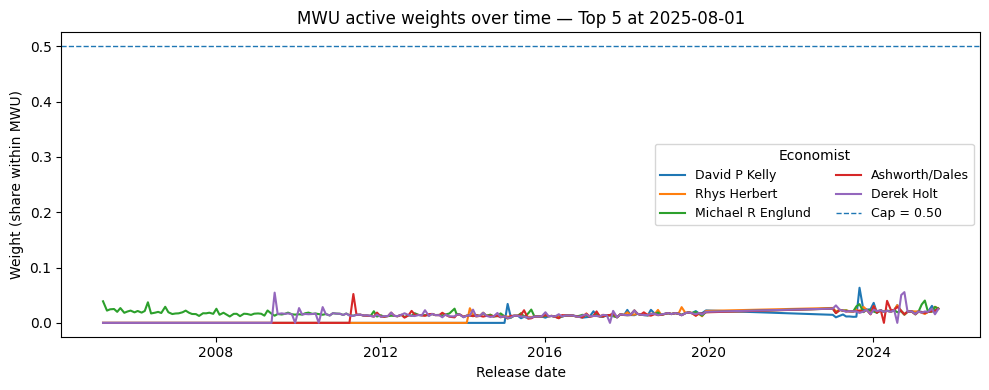

In [9]:
# === MWU: plot history for the Top-5 weighted in live snapshot ===
snap = pd.DataFrame(LIVE_WEIGHT_SNAPSHOTS)
if snap.empty or "mwu" not in snap.get("model", pd.Series()).unique():
    print("\n(No MWU snapshots found.)")
else:
    snap_mwu = snap[snap["model"] == "mwu"].copy()
    latest_date = snap_mwu["date"].max()
    latest = snap_mwu[snap_mwu["date"] == latest_date]
    if latest.empty:
        print("\n(No latest-date MWU snapshot; skipping plot.)")
    else:
        # --- Top-5 selection matches the table (normalize within latest date) ---
        w_latest = (latest.groupby("economist")["weight"].mean()
                           .pipe(lambda s: s / s.sum())
                           .sort_values(ascending=False))
        top5 = w_latest.head(5).index.tolist()

        # --- Build historical ACTIVE-weight matrix from mwu_w_hist_maps ---
        hist_rows = []
        for panel_name, spec_map in mwu_w_hist_maps.items():   # {"COVID": {...}, "Full": {...}}
            for spec_id, whist in spec_map.items():            # list[(date, pd.Series(weights))]
                for d, w_s in whist:
                    if not isinstance(w_s, pd.Series):
                        continue
                    if not any(e in w_s.index for e in top5):
                        continue
                    row = {e: float(w_s.get(e, 0.0)) for e in top5}  # ACTIVE weights (already capped)
                    hist_rows.append(pd.Series(row, name=pd.Timestamp(d)))

        if not hist_rows:
            print("\n(No historical MWU weights available for the Top-5; nothing to plot.)")
        else:
            wide_raw = pd.DataFrame(hist_rows).sort_index()
            # Average across specs/panels by calendar date (still <= cap)
            wide = wide_raw.groupby(wide_raw.index).mean().fillna(0.0)

            plt.figure(figsize=(10, 4))
            for econ in top5:
                if econ in wide.columns:
                    plt.plot(wide.index, wide[econ], label=econ)

            cap = WEIGHT_CAP if 'WEIGHT_CAP' in globals() else 0.25
            plt.axhline(cap, ls="--", linewidth=1, label=f"Cap = {cap:.2f}")
            plt.title(f"MWU active weights over time — Top 5 at {pd.Timestamp(latest_date).date()}")
            plt.xlabel("Release date"); plt.ylabel("Weight (share within MWU)")
            plt.legend(title="Economist", ncol=2, fontsize=9)
            plt.tight_layout(); plt.show()

            # Optional safety print
            mx = float(wide.max().max())
            if mx > cap + 1e-9:
                print(f"[WARN] Averaged series exceeds cap ({mx:.4f} > {cap}). Check snapshots.")


**Quick check before ensembles: remove dupes and check for coverage**

In [10]:
# =============================================================
#  House-keeping: de-dupe lists (in case of multiple runs of above cells) & verify model coverage
# =============================================================

# ---------- in-place de-duplication -----------------------
def _dedupe(lst: list[dict]):
    """Remove exact-duplicate dicts (order-preserving)."""
    seen, uniq = set(), []
    for d in lst:
        key = json.dumps(d, sort_keys=True, default=str)
        if key not in seen:
            seen.add(key); uniq.append(d)
    lst[:] = uniq          # mutate in place

for _name in ["LIVE_WEIGHT_SNAPSHOTS", "WEIGHT_HISTORY", "_all_eval", "_all_live"]:
    if _name in globals():
        _dedupe(globals()[_name])

# ---------- assert every model & panel has data -----------
REQUIRED_MODELS = {"inv_err", "ewma", "soft_bma", "mwu"}
REQUIRED_PANELS = {"COVID", "Full"}

def _is_empty(obj):
    """True if obj is an empty DataFrame OR an empty dict."""
    if obj is None:
        return True
    if isinstance(obj, pd.DataFrame):
        return obj.empty
    if isinstance(obj, dict):
        return len(obj) == 0
    return False

def _check(container: dict, name: str):
    """
    Checks that the global storage variables contain the required models for ensemble forecasting.
    """
    missing = {
        f"{mdl}:{p}"
        for mdl in REQUIRED_MODELS
        for p in REQUIRED_PANELS
        if mdl not in container
           or p not in container[mdl]
           or _is_empty(container[mdl][p])
    }
    assert not missing, (
        f"[ASSERT] {name} is missing or empty for "
        f"{', '.join(sorted(missing))}"
    )
    
    

_check(eval_tables, "eval_tables")
_check(live_tables, "live_tables")
_check(oos_maps,   "oos_maps")

print("All checks passed. Duplicates (if any) removed & all four models present for COVID & Full panels, ready for ensemble forecasting.")

All checks passed. Duplicates (if any) removed & all four models present for COVID & Full panels, ready for ensemble forecasting.


## 1.5 Selecting the “Most Accurate” Economists  
1. **Take the latest live-month snapshots** of economist weights from every ensemble model  
   * (Inverse-Error, EWMA, Soft-BMA, MWU).  

2. **Normalize within each model**  
   * For a given model, an economist’s weight = their average share of that model’s portfolio, so the weights sum to 100 % inside the model.  

3. **Blend the models equally**  
   * Give each model a fixed 25 % budget, then scale its internal weight vector accordingly.  

4. **Aggregate across models**  
   * FinalWeight (economist) = Σ (model-scaled weights).  
   * The blended vector still sums to 100 %.  

5. **Rank and report**  
   * Sort economists by FinalWeight to see who the system currently deems most influential.  
   * Display the top-10 list for each model **and** the overall blended top-10.

In [11]:
# concatenate everything into one table
master_eval = pd.concat(_all_eval, ignore_index=True)
master_live = pd.concat(_all_live, ignore_index=True)

In [12]:
#  Load the latest-month snapshot
live_w_df   = pd.DataFrame(LIVE_WEIGHT_SNAPSHOTS)
latest_date = live_w_df["date"].max()
latest_df   = live_w_df[live_w_df["date"] == latest_date].copy()

MODELS        = ["inv_err", "ewma", "soft_bma", "mwu"]   # expected layers
TARGET_SHARE  = 0.25                                     # 25 % per model
model_weights = {}                                       # {model: pd.Series}

pd.set_option("display.float_format", "{:.2%}".format)   # % formatting for display

#  Per-model weight vectors  +  per-model top-10 tables
for mdl in MODELS:
    g = latest_df[latest_df["model"] == mdl]
    if g.empty:
        print(f"[WARN] no live snapshot for model '{mdl}'")
        continue

    # average across specs & panels for *this* model
    w_mdl = g.groupby("economist")["weight"].mean()
    w_mdl = w_mdl / w_mdl.sum()            # weights sum to 1 within the model
    model_weights[mdl] = w_mdl

    # top-10 display
    top10_mdl = (w_mdl.sort_values(ascending=False)
                        .head(10)
                        .reset_index()
                        .rename(columns={"weight": "ModelWeight"}))
    print(f"\n=== {mdl.upper()} – Top 10 economists ({latest_date.date()}) ===")
    display(top10_mdl)

#  Equal-model blend (25 % each) for weight contribution
scaled_layers = [w * TARGET_SHARE for w in model_weights.values()]
overall_w     = (pd.concat(scaled_layers, axis=1)
                   .sum(axis=1)
                   .rename("FinalWeight"))

print(f"\nTotal weight after blend: {overall_w.sum():.4f}  (should be 1.0000)")

top10_overall = (overall_w.sort_values(ascending=False)
                            .head(10)
                            .reset_index()
                            .rename(columns={"FinalWeight": "Weight"}))

print(f"\n=== Equal-Model Blend – Top 10 economists ({latest_date.date()}) ===")
display(top10_overall)

pd.reset_option("display.float_format")


=== INV_ERR – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,3.90%
1,Seiji Katsurahata,3.11%
2,Ashworth/Dales,2.88%
3,Rhys Herbert,2.77%
4,Derek Holt,2.60%
5,Jason M Schenker,2.58%
6,Joe Brusuelas/Tuan Nguyen,2.50%
7,Michael R Englund,2.49%
8,Russell T Price,2.45%
9,Michael E Feroli,2.42%



=== EWMA – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,3.99%
1,Seiji Katsurahata,3.19%
2,Ashworth/Dales,3.05%
3,Rhys Herbert,3.03%
4,Jason M Schenker,2.69%
5,Derek Holt,2.68%
6,Michael R Englund,2.63%
7,Joe Brusuelas/Tuan Nguyen,2.51%
8,Michael E Feroli,2.50%
9,Oscar Munoz,2.43%



=== SOFT_BMA – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,10.91%
1,Seiji Katsurahata,7.43%
2,Russell T Price,6.10%
3,David H Sloan,4.97%
4,Derek Holt,4.69%
5,Richard F Moody,4.65%
6,Ashworth/Dales,4.35%
7,Joe Brusuelas/Tuan Nguyen,4.32%
8,Rhys Herbert,3.38%
9,James Egelhof,3.19%



=== MWU – Top 10 economists (2025-08-01) ===


,economist,ModelWeight
0,David P Kelly,2.64%
1,Rhys Herbert,2.59%
2,Michael R Englund,2.56%
3,Ashworth/Dales,2.54%
4,Derek Holt,2.48%
5,Peter G Morici,2.41%
6,Besch/Luetje,2.41%
7,Andreas Busch,2.41%
8,Seiji Katsurahata,2.39%
9,Jason M Schenker,2.36%



Total weight after blend: 1.0000  (should be 1.0000)

=== Equal-Model Blend – Top 10 economists (2025-08-01) ===


,economist,Weight
0,David P Kelly,5.36%
1,Seiji Katsurahata,4.03%
2,Russell T Price,3.28%
3,Ashworth/Dales,3.20%
4,Derek Holt,3.11%
5,Rhys Herbert,2.94%
6,Joe Brusuelas/Tuan Nguyen,2.88%
7,David H Sloan,2.86%
8,Richard F Moody,2.74%
9,Jason M Schenker,2.52%


## 1.6 In-Sample “Robust-Ensemble” Search  
*(build a tiny basket of the strongest spec-level models and take a simple vote)*  

1. **Create the candidate pool**  
   * From every underlying method, grab the spec with  
     - lowest RMSE,  
     - highest hit-rate, and  
     - any “robust-winner” that beats the median **and** passes the Diebold-Mariano & Pesaran-Timmermann tests ( *p < 0.10 ).*  
   * Deduplicate → a short list of high-quality individual specs.

2. **Collect their full out-of-sample tracks** on the **Full** panel.  
   * Only specs that have a complete OOS history survive.

3. **Exhaustive search over small baskets**  
   * Basket size **k = {3, 5}**.
   * For each time-window (`FULL`, trailing 12 / 6 / 3 months) test **every combination** of *k* specs.

4. **Evaluate each basket**  
   * **Ensemble forecast** = simple average of member “smart” forecasts (we don't use this, primarily interested in directional).  
   * **Directional signal** = majority vote (≥ 50 %) of member directions.  
   * Record overall hit-rate, Binomial p-value, PT p-value and an **Accuracy × Consistency** score  
     \[(1 − HitRate) + λ·σ\_{HitRate across regimes}, with λ = 1\].

5. **Pick the best basket per window** (highest hit-rate; ties broken by AC-score).  

6. **Generate the live month verdict (if applicable, most recent month actual = NA)**  
   * Apply the same majority vote on the latest unreleased month to output a **“Beat / Miss”** consensus signal.  
   * Print ensemble members, live median, and stratified diagnostics for transparency.
7. **Optional alternative candidate pool procedure**
   * Build candidate spec pool by selecting *highest hit rate* specifications instead of the HR/RMSE/Robust procedure outlined in step 1. Set RUN_TOP_HR_POOL = True and specify a value for TOP_HR_N to activate.
   * An alternative candidate pool building procedure; can try if initial results with previous candidate pool are below expectations

In [13]:
# -------------------------------------------------------------
#  In‑sample robust‑ensemble search  (k = 3, 5)
# -------------------------------------------------------------

# ─────────────────────  SETTINGS  ────────────────────────────
TODAY   = pd.Timestamp.today().normalize()

WINDOW_OFFSETS = {         # how many realized months we want
    "FULL": None,          # special case → use the whole history
    "T12M": 12,
    "T6M" :  6,
    "T3M" :  3,
}
LAMBDA_AC = 1.0                 # weight on consistency term in AC‑score. 1.0 = weighing accuracy and consistency equally

# optional hyperparams for alternative candidate pool selection
TOP_HR_N = 15                   # how many top-HitRate specs to include in alt pool
RUN_TOP_HR_POOL = False         # if True, also run the Top-HR pool search and print results after baseline


# candidate pool 
pool = set()
for model_id, panel_map in eval_tables.items():
    for panel in ["COVID", "Full"]:
        eval_df_tmp = panel_map.get(panel)
        if eval_df_tmp is None or eval_df_tmp.empty:
            continue
        pool.add(eval_df_tmp.loc[eval_df_tmp["RMSE_smart"].idxmin(), "spec_id"])
        pool.add(eval_df_tmp.loc[eval_df_tmp["HitRate"].idxmax(),    "spec_id"])
        rob = eval_df_tmp[(eval_df_tmp["DM_p"] < .10) & (eval_df_tmp["PT_p"] < .10)]
        if not rob.empty:
            pool.add(rob.loc[rob["RMSE_smart"].idxmin(), "spec_id"])

pool = sorted(pool)
print(f"Total unique candidate specs selected: {len(pool)}")

# ─────────── 2) collect FULL‑panel OOS frames  ───────────────
oos_full = {}
for mdl, panel_map in oos_maps.items():
    oos_full.update(panel_map.get("Full", {}))

pool = [s for s in pool if s in oos_full]
assert len(pool) >= 3, "Need ≥3 viable specs with Full‑panel OOS"
print(f"Usable specs with Full‑panel OOS: {len(pool)}\n")

# ─────────── 3) helpers  ─────────────────────────────────────
def _window_slice(df_all: pd.DataFrame,
                  months_back: Optional[int]) -> pd.DataFrame:
    """
    Keep data *up to* the last realised month, and (optionally) only the
    most-recent `months_back` realised months.

    Parameters
    ----------
    df_all : merged OOS frame for one combo
    months_back : int | None
        • None  → use the whole realised history  
        • n     → keep exactly the last *n* realised months
    """
    # last realised month in *this combo*
    last_realised = df_all.loc[df_all["actual"].notna(), "date"].max()
    if pd.isna(last_realised):
        return df_all.iloc[0:0]              # nothing realised yet

    # rows we are ever allowed to use
    realised_mask = df_all["date"] <= last_realised
    realised_df   = df_all.loc[realised_mask]

    if months_back is None:
        return realised_df                   # FULL window

    # figure out where the moving window should start
    t_start = (last_realised - pd.DateOffset(months=months_back)
               + MonthBegin())
    return realised_df.loc[realised_df["date"] >= t_start]

def merged_oos(combo: Tuple[str, ...]) -> pd.DataFrame:
    """Merge members; keep each smart forecast for majority vote."""
    dfs: List[pd.DataFrame] = []
    for i, sid in enumerate(combo):
        tmp = (oos_full[sid][["date", "smart", "median", "actual"]]
               .rename(columns={"smart":  f"smart_{i}",
                                "median": f"median_{i}",
                                "actual": f"actual_{i}"}))
        dfs.append(tmp)
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on="date")

    df["median"] = df["median_0"]
    df["actual"] = df["actual_0"]
    smart_cols   = [c for c in df.columns if c.startswith("smart_")]
    df["ens"]    = df[smart_cols].mean(axis=1)
    return df[["date", "ens", "median", "actual", *smart_cols]]

def dir_metrics(df: pd.DataFrame):
    """Hit‑Rate, Binom‑p, PT‑p with majority‑vote direction."""
    realised = df.dropna(subset=["actual"]).copy()
    if realised.empty:
        return np.nan, 0, np.nan, np.nan

    smart_cols = [c for c in realised.columns if c.startswith("smart_")]
    votes      = realised[smart_cols].gt(realised["median"], axis=0).sum(axis=1)
    realised["pred_dir"]   = (votes > len(smart_cols) / 2).astype(int)
    realised["actual_dir"] = (realised["actual"] > realised["median"]).astype(int)

    hits  = (realised["pred_dir"] == realised["actual_dir"]).sum()
    n     = len(realised)
    hr    = hits / n
    binom = stats.binomtest(hits, n, .5).pvalue
    p1, p2  = realised["pred_dir"].mean(), realised["actual_dir"].mean()
    c_joint = (realised["pred_dir"] & realised["actual_dir"]).mean()
    pt_p = 2*(1 - stats.norm.cdf(abs((c_joint - p1*p2) /
                                     math.sqrt(p1*p2*(1-p1)*(1-p2)/n))))
    return hr, n, binom, pt_p

def stratified_table(df_all: pd.DataFrame) -> pd.DataFrame:
    """
    Dynamic-anchor regime diagnostics for a single ensemble combo.
    """
    # keep only realised months
    realised = df_all[df_all["actual"].notna()].copy()
    if realised.empty:
        return pd.DataFrame()

    # use the common helper to build the dynamic regime map
    dyn_regimes = _dynamic_regimes(realised)

    rows = []
    for lbl, (start, end) in dyn_regimes.items():
        sub = realised[(realised["date"] >= pd.Timestamp(start)) &
                       (realised["date"] <= pd.Timestamp(end))]
        hr, n, bp, pt = dir_metrics(sub)          # reuse existing helper
        if math.isnan(hr):
            continue
        rows.append({
            "Regime":   lbl,
            "Obs":      n,
            "HitRate":  hr,
            "Binom_p":  bp,
            "PT_p":     pt
        })
    return pd.DataFrame(rows)


def ac_score(overall_hr: float, block_hr: pd.Series, lam: float = LAMBDA_AC):
    """Compute Accuracy × Consistency score (lower = better)."""
    if block_hr.empty or len(block_hr) < 2:
        return np.nan
    return (1 - overall_hr) + lam * block_hr.std(ddof=1)

# --- helper to run the exhaustive search and print summary ---
def _run_ensemble_search_for_pool(pool, label_suffix=""):
    if len(pool) < 3:
        print(f"[{label_suffix or 'BASE'}] Skipping: pool too small (<3)\n")
        return None

    summary_rows_local, verdict_votes_local = [], []

    for k in (3, 5):
        if len(pool) < k:
            print(f"[{label_suffix or 'BASE'}] Skipping k={k}: pool too small\n")
            continue

        for win_lbl, m_back in WINDOW_OFFSETS.items():
            best = {"combo": None, "hr": -np.inf}

            for combo in itertools.combinations(pool, k):
                df_all  = merged_oos(combo)
                df_eval = _window_slice(df_all, m_back)
                hr, n, bp, pt = dir_metrics(df_eval)
                if hr > best["hr"]:
                    best.update({"combo": combo, "hr": hr, "n": n,
                                 "binom": bp, "pt": pt, "df_full": df_all})

            # ---------- live signal ----------
            ens_df = best["df_full"]
            unreleased = ens_df[ens_df["actual"].isna()].sort_values("date")
            if not unreleased.empty:
                last = unreleased.iloc[-1]
                smart_cols = [c for c in last.index if c.startswith("smart_")]
                votes      = sum(last[c] > last["median"] for c in smart_cols)
                best["signal"]      = "Beat" if votes > len(smart_cols)/2 else "Miss"
                best["median_live"] = last["median"]
            else:
                best["signal"], best["median_live"] = "n/a", np.nan

            # ---------- regime diagnostics & AC-score ----------
            st_table = stratified_table(ens_df)
            core_blocks = st_table.loc[~st_table["Regime"].str.startswith("Trailing")]
            best["ac_score"] = ac_score(best["hr"], core_blocks["HitRate"]) if not core_blocks.empty else np.nan

            # ---------- pretty print ----------
            prefix = f"[{win_lbl}{(' • ' + label_suffix) if label_suffix else ''}]"
            print(f"{prefix}  Best ensemble  k={k}")
            print(f"  Specs        : {best['combo']}")
            print(f"  HitRate      : {best['hr']:.2%}  over {best['n']} months")
            print(f"  Binom p-val  : {best['binom']:.3f}   PT p-val : {best['pt']:.3f}")
            print(f"  AC-score(λ={LAMBDA_AC}) : {best['ac_score']:.4f}")
            if best["signal"] != "n/a":
                print(f"  Consensus med: {best['median_live']:.0f} k")
            print(f"  Live signal  : {best['signal']}")
            if not st_table.empty:
                print("  Stratified performance:")
                print(st_table.to_string(index=False, float_format=lambda x: f"{x:0.3f}"))
            print()

            summary_rows_local.append({
                "Window": win_lbl, "k": k,
                "Specs": best["combo"],
                "HitRate": best["hr"], "Obs": best["n"],
                "Binom_p": best["binom"], "PT_p": best["pt"],
                f"ACλ={LAMBDA_AC}": best["ac_score"],
                "LiveSignal": best["signal"],
                "Pool": label_suffix or "BASE"
            })
            verdict_votes_local.append(best["signal"])
            
    summary_df_local = (pd.DataFrame(summary_rows_local)
                        .sort_values(["Window", "k"])
                        .reset_index(drop=True))

    def _dedup_windows_local(df: pd.DataFrame) -> pd.DataFrame:
        chosen = []
        for win, grp in df.groupby("Window", sort=False):
            if len(grp) == 1:
                chosen.append(grp.iloc[0]); continue
            hr_max = grp["HitRate"].max()
            top    = grp[grp["HitRate"] == hr_max]
            if len(top) == 1:
                chosen.append(top.iloc[0])
            else:
                signals = top["LiveSignal"].unique()
                if len(signals) == 1:
                    row3 = top[top["k"] == 3]
                    chosen.append(row3.iloc[0] if not row3.empty else top.iloc[0])
                else:
                    chosen.extend(top.itertuples(index=False))
        return pd.DataFrame(chosen).sort_values("Window").reset_index(drop=True)

    pruned_local = _dedup_windows_local(summary_df_local)
    pd.set_option("display.float_format", "{:.3f}".format)
    header = f"================  ENSEMBLE SUMMARY ({label_suffix or 'BASE'})  ================"
    print(f"\n{header}\n")
    print(pruned_local.to_string(index=False))

    return pruned_local

# === Run baseline search using the original candidate pool (RMSE/HR/Robust) ===
_ = _run_ensemble_search_for_pool(pool, label_suffix="Baseline (RMSE/HR/Robust)")

# === OPTIONAL: Run alternative Top-HitRate candidate-pool strategy ===
if RUN_TOP_HR_POOL:
    # Gather all eval rows across models/panels, rank by HitRate
    eval_all = []
    for model_id, panel_map in eval_tables.items():
        for panel in panel_map:
            df_eval = panel_map.get(panel)
            if df_eval is not None and not df_eval.empty:
                eval_all.append(df_eval.assign(model_id=model_id, panel=panel))
    eval_all = pd.concat(eval_all, ignore_index=True) if eval_all else pd.DataFrame()

    if eval_all.empty:
        print("\n[Top-HR] No eval rows available.")
    else:
        # Keep only specs with realised observations; sort by HitRate desc; take top N unique specs
        top_rows = (eval_all[eval_all["obs"] > 0]
                    .sort_values("HitRate", ascending=False)
                    .drop_duplicates(subset=["spec_id"])
                    .head(TOP_HR_N))

        # Only specs that have Full-panel OOS are usable
        alt_pool = [sid for sid in top_rows["spec_id"].tolist() if sid in oos_full]

        print(f"\n[Top-HR] Requested TOP_HR_N = {TOP_HR_N}")
        print(f"[Top-HR] Usable specs with Full-panel OOS: {len(alt_pool)}\n")

        _ = _run_ensemble_search_for_pool(alt_pool, label_suffix=f"Top-HR pool (N={TOP_HR_N})")

Total unique candidate specs selected: 12
Usable specs with Full‑panel OOS: 12

[FULL • Baseline (RMSE/HR/Robust)]  Best ensemble  k=3
  Specs        : ('ewma_w3_d0.75_mequal_weight', 'ewma_w6_d0.75_mequal_weight', 'inv_err_w6_mequal_weight')
  HitRate      : 58.46%  over 260 months
  Binom p-val  : 0.008   PT p-val : 0.007
  AC-score(λ=1.0) : 0.5144
  Consensus med: 105 k
  Live signal  : Beat
  Stratified performance:
                            Regime  Obs  HitRate  Binom_p  PT_p
      2003-12 to 2007-12 (pre-GFC)   49    0.551    0.568 0.458
          2008-01 to 2009-12 (GFC)   24    0.792    0.007 0.005
 2010-01-2014-12 (early-expansion)   60    0.583    0.245 0.201
  2015-01-2019-12 (late-expansion)   60    0.550    0.519 0.405
        2020-01 to 2022-12 (COVID)   36    0.611    0.243 0.196
2023-01 to 2025-07-03 (post-COVID)   31    0.516    1.000 0.535
                Trailing 24-months   24    0.500    1.000 0.770
                Trailing 12-months   12    0.417    0.774 0.679


## 1.7 Dynamic Rolling Majority-Vote Ensemble  
*(fully out-of-sample, walk-forward benchmark that lets the “best combo” evolve through time)*  

1. **Monthly candidate pool**  
   * Up to each month *t – 1*, compute basic stats (hit-rate, RMSE, DM & PT p-values) for **every** spec.  
   * Select the “low-RMSE”, “high-HR”, and any *robust* spec (both DM & PT p < 0.10) **within each underlying model**.  
   * Result: a small but diverse set of high-quality specs ready for the vote.

2. **Pick the current all-star team**  
   * For each trailing window — **3, 6, 12 months** — search **all combos of k = 3 and 5** specs from the pool.  
   * Score each combo on rolling hit-rate (ties → lower RMSE tiebreak).  
   * Store the window-wise winner; the overall “**bestHR**” is the window with the highest hit-rate.

3. **Live-month forecast**  
   * For each winner (T3, T6, T12) output **Beat / Miss** depending on whether the combo average beats the median.  

   
4. **Back-test diagnostics**  
   * Tracks cumulative hit-rate of each window’s winning combo over time.  
   * Computes per-regime accuracy, binomial & PT p-values, plus an **Accuracy × Consistency** score  
     \[(1 − overall HR) + λ·σ\_{regime HR}, λ = 1\].  
   * Benchmarks against the **baseline** hit-rate of individual economists.

5. **Visual output**  
   * Table of stratified performance for every ensemble.  
   * Rolling hit-rate plot of the three time-window winners (T3, T6, T12) with a 50 % reference line.

Rolling evaluation:   0%|          | 0/264 [00:00<?, ?month/s]


--- Stratified diagnostics for T3 ---
                            Regime  Obs  HitRate  Binom_p  PT_p
      2004-09 to 2007-12 (pre-GFC)   40    0.475    0.875 0.726
          2008-01 to 2009-12 (GFC)   24    0.708    0.064 0.035
 2010-01-2014-12 (early-expansion)   60    0.533    0.699 0.628
  2015-01-2019-12 (late-expansion)   60    0.600    0.155 0.100
        2020-01 to 2022-12 (COVID)   36    0.639    0.132 0.220
2023-01 to 2025-07-03 (post-COVID)   31    0.548    0.720 0.593
                Trailing 24-months   24    0.458    0.839 0.371
                Trailing 12-months   12    0.333    0.388 0.276
                 Trailing 6-months    6    0.000    0.031 0.014
                 Trailing 3-months    3    0.000    0.250 1.000
Accuracy × Consistency (λ = 1.0):  0.509


--- Stratified diagnostics for T6 ---
                            Regime  Obs  HitRate  Binom_p  PT_p
      2004-09 to 2007-12 (pre-GFC)   40    0.475    0.875 0.775
          2008-01 to 2009-12 (GFC)   24    0.750

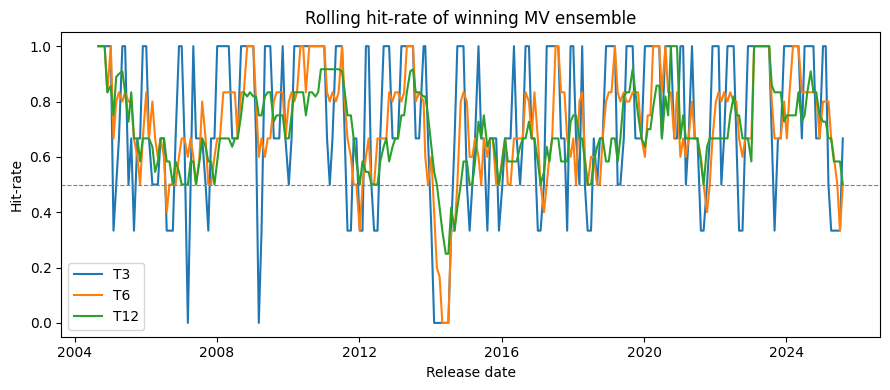

In [14]:
# =============================================================
#  Dynamic majority-vote ensembles, baseline benchmark
# =============================================================

# ---------- hyperparameters & regimes -----------------------
WINDOWS    = {3: "T3", 6: "T6", 12: "T12"}
K_SET      = (3, 5)
ALPHA      = 0.10
LAMBDA_AC  = 1.0

# ---- toggle to use average-of-smart instead of majority vote for ensemble (we default to majority vote as preferred)
USE_AVG_DIR = False  

def _avg_hitrate(df: pd.DataFrame) -> float:
    """Hit-rate when direction is decided by ensemble average (ens) vs median."""
    if "ens" not in df or "median" not in df:
        return np.nan
    sub = df.dropna(subset=["actual"]).copy()
    if sub.empty:
        return np.nan
    pred_dir = (sub["ens"]    > sub["median"]).astype(int)
    act_dir  = (sub["actual"] > sub["median"]).astype(int)
    return (pred_dir == act_dir).mean()

def _dir_hitrate(df: pd.DataFrame) -> float:
    """Dispatch to avg-based or vote-based hit-rate."""
    return _avg_hitrate(df) if USE_AVG_DIR else _mv_hitrate(df)

def _avg_pred_dir_for_date(combo, t_date):
    """Per-date predicted direction using average-of-smart vs median."""
    df = _merged_oos_cached(combo)
    row = df.loc[df["date"] == t_date]
    if row.empty:
        return np.nan
    return int(row["ens"].iloc[0] > row["median"].iloc[0])

def _actual_dir_for_date_simple(combo, t_date):
    """Actual direction vs median (no 'vote' for actual)."""
    df  = _merged_oos_cached(combo)
    row = df.loc[df["date"] == t_date]
    if row.empty:
        return np.nan
    return int(row["actual"].iloc[0] > row["median"].iloc[0])

# ---------- helper functions ---------------------------------
def _spec_metrics(oos: pd.DataFrame) -> dict:
    """Basic directional stats for one spec up to a cut-off date (oos already filtered)."""
    df = oos.dropna(subset=["actual"]).copy()
    if df.empty:
        return {"obs": 0, "rmse": np.nan, "hr": np.nan,
                "dm_p": np.nan, "pt_p": np.nan}

    df["smart_err"]  = df["smart"]  - df["actual"]
    df["median_err"] = df["median"] - df["actual"]
    df["pred_dir"]   = (df["smart"] > df["median"]).astype(int)
    df["actual_dir"] = (df["actual"] > df["median"]).astype(int)

    obs  = len(df)
    rmse = np.sqrt((df["smart_err"]**2).mean())
    hr   = (df["pred_dir"] == df["actual_dir"]).mean()

    diff = df["smart_err"]**2 - df["median_err"]**2
    dm_p = (1.0 if diff.std(ddof=1) == 0 else
            2*(1 - stats.norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs)))))

    p1, p2 = df["pred_dir"].mean(), df["actual_dir"].mean()
    denom  = p1*p2*(1-p1)*(1-p2)
    pt_p   = 1.0 if denom == 0 else \
             2*(1 - stats.norm.cdf(abs(((df["pred_dir"] & df["actual_dir"]).mean()-p1*p2) /
                                        math.sqrt(denom/obs))))
    return {"obs": obs, "rmse": rmse, "hr": hr, "dm_p": dm_p, "pt_p": pt_p}

def _candidate_pool(stats_df: pd.DataFrame) -> list[str]:
    """Specs that win lowest-RMSE / highest-HR / robust filters within the cut-off date."""
    chosen = set()
    for _, grp in stats_df.groupby(["model", "panel"]):
        grp = grp[grp["obs"] > 0]
        if grp.empty:
            continue
        chosen.add(grp.loc[grp["rmse"].idxmin(), "spec_id"])
        chosen.add(grp.loc[grp["hr"  ].idxmax(), "spec_id"])
        rob = grp[(grp["dm_p"] < ALPHA) & (grp["pt_p"] < ALPHA)]
        if not rob.empty:
            chosen.add(rob.loc[rob["rmse"].idxmin(), "spec_id"])
    return sorted(chosen)

# --- OOS look-ups --------------------------------------------
oos_full = {}
for mdl, pnl_map in oos_maps.items():
    oos_full.update(pnl_map.get("Full", {}))

def merged_oos(combo: tuple[str, ...]) -> pd.DataFrame:
    dfs = []
    for i, sid in enumerate(combo):
        tmp = (oos_full[sid][["date", "smart", "median", "actual"]]
               .rename(columns={"smart":  f"smart_{i}",
                                "median": f"median_{i}",
                                "actual": f"actual_{i}"}))
        dfs.append(tmp)
    df = dfs[0]
    for d in dfs[1:]:
        df = df.merge(d, on="date")

    smart_cols = [c for c in df.columns if c.startswith("smart_")]

    # one ensemble point forecast
    df["ens"] = df[smart_cols].mean(axis=1)

    # one shared actual + one shared median (use the first; they should be identical)
    df["actual"] = df["actual_0"]
    df["median"] = df["median_0"]

    # (optional) sanity check all medians match
    if not np.allclose(df.filter(like="median_").to_numpy(),
                       df[["median"]].to_numpy().repeat(len(smart_cols), axis=1),
                       equal_nan=True):
        raise ValueError("Per-spec medians differ for the same release date")

    return df[["date", "ens", "median", "actual", *smart_cols]]



_combo_cache: dict[tuple[str, ...], pd.DataFrame] = {}
def _merged_oos_cached(combo: tuple[str, ...]) -> pd.DataFrame:
    if combo not in _combo_cache:
        _combo_cache[combo] = merged_oos(combo)
    return _combo_cache[combo]

def _mv_hitrate(df: pd.DataFrame) -> float:
    smart_cols = [c for c in df.columns if c.startswith("smart_")]
    if not smart_cols or "median" not in df: 
        return np.nan
    votes_pred = df[smart_cols].gt(df["median"], axis=0).sum(axis=1)
    votes_act  = df["median"].rsub(df["actual"]).lt(0).astype(int)  # equivalent to (actual > median)
    # but we need count across members for act votes, so:
    votes_act  = df[["median"]].lt(df["actual"], axis=0).to_numpy().repeat(len(smart_cols), axis=1).sum(axis=1)
    maj = len(smart_cols) / 2.0
    pred_dir = votes_pred > maj
    act_dir  = votes_act  > maj
    return (pred_dir == act_dir).mean()

def _combo_hitrate(combo, t_cut, window):
    df = _merged_oos_cached(combo)
    sub = df[(df["date"] >= t_cut - pd.DateOffset(months=window)) &
             (df["date"] <  t_cut) &
             df["actual"].notna()]
    return _dir_hitrate(sub), len(sub)

def _window_rmse(combo, t_cut, window):
    df = _merged_oos_cached(combo)
    sub = df[(df["date"] >= t_cut - pd.DateOffset(months=window)) &
             (df["date"] <  t_cut) &
             df["actual"].notna()]
    return np.inf if sub.empty else np.sqrt(((sub["ens"] - sub["actual"])**2).mean())

def _choose_best_combo(pool, t_cut, window):
    best_combo, best_hr, best_rmse = None, -1.0, np.inf
    for k in K_SET:
        if len(pool) < k:
            continue
        for combo in itertools.combinations(pool, k):
            hr, _ = _combo_hitrate(combo, t_cut, window)
            if math.isnan(hr):
                continue
            if hr > best_hr:
                best_combo, best_hr = combo, hr
                best_rmse = _window_rmse(combo, t_cut, window)
            elif hr == best_hr:
                rmse = _window_rmse(combo, t_cut, window)
                if rmse < best_rmse or (rmse == best_rmse and combo < best_combo):
                    best_combo, best_rmse = combo, rmse
    return best_combo, best_hr

# --- per-date majority direction using per-member medians
def _mv_pred_dir_for_date(combo, t_date):
    df = _merged_oos_cached(combo)
    row = df[df["date"] == t_date]
    if row.empty: return np.nan
    smart_cols = [c for c in df.columns if c.startswith("smart_")]
    votes = (row[smart_cols].to_numpy() > row[["median"]].to_numpy()).sum(axis=1)[0]
    return int(votes > len(smart_cols)/2)

def _actual_dir_for_date(combo, t_date):
    df = _merged_oos_cached(combo)
    row = df[df["date"] == t_date]
    if row.empty: return np.nan
    # same median for all members → either 0 or k votes at once
    k = len([c for c in df.columns if c.startswith("smart_")])
    votes = k if (row["actual"].iloc[0] > row["median"].iloc[0]) else 0
    return int(votes > k/2)

def _ac_score(overall_hr, reg_hits, lam=LAMBDA_AC):
    return np.nan if len(reg_hits) < 2 or math.isnan(overall_hr) else \
           (1 - overall_hr) + lam * np.std(reg_hits, ddof=1)

def strat_using_baseline_map(dfp: pd.DataFrame, include_trailing: bool = True) -> pd.DataFrame:
    """
    Stratified diagnostics using the baseline-anchored dynamic regimes (_dyn_regimes_bl).
    Set include_trailing=False to drop trailing windows (T24/T12/T6) from the output.
    """
    if "actual_dir" not in dfp.columns:
        return pd.DataFrame()
    realised = dfp[dfp.get("actual_dir").notna()].copy()
    if realised.empty:
        return pd.DataFrame()

    realised["pred_dir"]   = realised["pred_dir"].astype(int)
    realised["actual_dir"] = realised["actual_dir"].astype(int)

    rows = []
    for lbl, (start, end) in _dyn_regimes_bl.items():
        if not include_trailing and lbl.startswith("Trailing"):
            continue

        sub = realised[(realised["date"] >= pd.Timestamp(start)) &
                       (realised["date"] <= pd.Timestamp(end))]
        if sub.empty:
            continue

        hits    = (sub["pred_dir"] == sub["actual_dir"]).sum()
        n       = len(sub)
        hr      = hits / n
        binom_p = stats.binomtest(hits, n, .5).pvalue

        p1, p2  = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        denom   = p1 * p2 * (1 - p1) * (1 - p2)
        pt_p    = (1.0 if denom == 0 else
                   2 * (1 - stats.norm.cdf(
                       abs(((sub["pred_dir"] & sub["actual_dir"]).mean() - p1 * p2) /
                           math.sqrt(denom / n))
                   )))

        rows.append({"Regime": lbl, "Obs": n, "HitRate": hr,
                     "Binom_p": binom_p, "PT_p": pt_p})

    return pd.DataFrame(rows)

# -------------------------------------------------------------
# Rolling evaluation (dynamic warm-up)
# -------------------------------------------------------------
TAG_BASE = ["T3", "T6", "T12"]
records   = {tag: [] for tag in TAG_BASE}
sel_hr_ts = {tag: [] for tag in TAG_BASE}

cum_hits, cum_obs = defaultdict(int), defaultdict(int)

# Track the latest available combo per tag across the rolling loop
latest_combo_for_tag = {t: None for t in TAG_BASE}


all_dates = sorted({pd.to_datetime(d)
                    for mdl in oos_maps.values()
                    for pnl in mdl.values()
                    for o   in pnl.values()
                    for d   in o["date"].unique()})

sample_oos_any = next(iter(oos_maps[next(iter(oos_maps))]["Full"].values()))

PRED_FN   = _avg_pred_dir_for_date if USE_AVG_DIR else _mv_pred_dir_for_date
ACTUAL_FN = _actual_dir_for_date_simple  # actual always simple vs median

for t in tqdm(all_dates, desc="Rolling evaluation", unit="month"):
    # per-spec metrics up to t-1
    rows = []
    for m_id, pnl_map in oos_maps.items():
        for p_name, specs in pnl_map.items():
            for sid, oos in specs.items():
                met = _spec_metrics(oos[oos["date"] < t])
                met.update(model=m_id, panel=p_name, spec_id=sid)
                rows.append(met)
    stats_df = pd.DataFrame(rows)
    if stats_df["obs"].max() < 12:
        continue

    pool = _candidate_pool(stats_df)
    if len(pool) < 3:
        continue

    best_combo, win_hr = {}, {}
    for W in WINDOWS:
        combo, hr = _choose_best_combo(pool, t, W)
        if combo is not None:
            tag = WINDOWS[W]
            best_combo[tag] = combo
            win_hr[tag]     = hr

    if not set(TAG_BASE).issubset(best_combo):
        continue

    actual_known = pd.notna(
        sample_oos_any.loc[sample_oos_any["date"] == t, "actual"].iloc[0])

    # --- use the consistent dir functions in the roll
    for tag, combo in best_combo.items():
        latest_combo_for_tag[tag] = combo
        pred_dir = PRED_FN(combo, t) 
        rec = {"date": t, "pred_dir": pred_dir}

        # label with the SAME thresholds the combo used that month
        if actual_known:
            rec["actual_dir"] = ACTUAL_FN(combo, t)
            rec["hit"] = int(rec["pred_dir"] == rec["actual_dir"])
        records[tag].append(rec)


        if tag in sel_hr_ts:
            sel_hr_ts[tag].append((t, win_hr[tag]))

        if tag in TAG_BASE and actual_known:
            cum_hits[combo] += rec["hit"]
            cum_obs [combo] += 1

# -------------------------------------------------------------
# Baseline • “average of economist-level hit-rates”  
# -------------------------------------------------------------
# build a realised-only frame for every economist on the evaluation dates
eval_dates = {rec["date"] for rec in records["T3"] if "hit" in rec}

baseline_df = (df_full
               .dropna(subset=["actual"])
               .loc[lambda d: d["release_date"].isin(eval_dates)]
               .copy())

baseline_df["pred_dir"]   = (baseline_df["forecast"] > baseline_df["median_forecast"]).astype(int)
baseline_df["actual_dir"] = (baseline_df["actual"]   > baseline_df["median_forecast"]).astype(int)
baseline_df["hit"]        = (baseline_df["pred_dir"] == baseline_df["actual_dir"]).astype(int)

tmp = (baseline_df.drop(columns=[c for c in ["date"] if c in baseline_df.columns])
                  .rename(columns={"release_date": "date"}))
tmp["date"] = pd.to_datetime(tmp["date"])
_dyn_regimes_bl = _dynamic_regimes(tmp)

# regime-by-regime baseline table
def _baseline_strat(df: pd.DataFrame, *, regimes: dict) -> pd.DataFrame:
    """
    For each (dynamic) regime:
      • compute every economist’s own hit-rate within that block;
      • take the simple average of those per-economist hit-rates.
    """
    rows = []
    for lbl, (s, e) in regimes.items():
        sub = df[(df["release_date"] >= s) & (df["release_date"] <= e)]
        if sub.empty:
            continue
        econ_hr = sub.groupby("economist")["hit"].mean()    # each economist’s HR
        rows.append({
            "Regime":   lbl,
            "Obs":      econ_hr.count(),                    # # of economists active
            "HitRate":  econ_hr.mean()                      # average of economist HRs
        })
    return pd.DataFrame(rows)

baseline_strat = _baseline_strat(baseline_df, regimes=_dyn_regimes_bl)

# 4) overall baseline HR = average of economist-level HRs across *all* realised data
baseline_overall_hr = (
    baseline_df.groupby("economist")["hit"].mean()
).mean() if not baseline_df.empty else np.nan

# -------------------------------------------------------------
# Summaries & diagnostics  (incl. Baseline)  — unchanged except for the new vars
# -------------------------------------------------------------
summary_rows, strat_tables = [], {}
for tag, recs in records.items():
    dfp = (pd.DataFrame(recs)
            .dropna(subset=["hit", "pred_dir", "actual_dir"])
            .assign(
                pred_dir=lambda d: d["pred_dir"].astype(int),
                actual_dir=lambda d: d["actual_dir"].astype(int)
            ))

    ov_hr = dfp["hit"].mean() if not dfp.empty else np.nan

    # Full strat table for printing (includes trailing)
    strat = strat_using_baseline_map(dfp, include_trailing=True) if not dfp.empty else pd.DataFrame()
    if not strat.empty:
        strat_tables[tag] = strat

    # AC should be computed on CORE regimes only (drop "Trailing*")
    strat_core = strat.loc[~strat["Regime"].str.startswith("Trailing")] if not strat.empty else pd.DataFrame()
    ac = _ac_score(ov_hr, strat_core["HitRate"], LAMBDA_AC) if (not strat_core.empty) else np.nan

    summary_rows.append({"Method": tag, "Obs": len(dfp),
                         "HitRate": ov_hr, f"ACλ={LAMBDA_AC}": ac})


# Keep full baseline strat for printing
strat_tables["Baseline"] = baseline_strat

# but compute AC on CORE regimes only
baseline_strat_core = baseline_strat.loc[~baseline_strat["Regime"].str.startswith("Trailing")] \
                        if not baseline_strat.empty else pd.DataFrame()

summary_rows.append({
    "Method": "Baseline",
    "Obs": baseline_df["economist"].nunique(),
    "HitRate": baseline_overall_hr,
    f"ACλ={LAMBDA_AC}": _ac_score(baseline_overall_hr,
                                  baseline_strat_core["HitRate"],
                                  LAMBDA_AC) if not baseline_strat_core.empty else np.nan
})

# ---------- console output ------------------------
pd.set_option("display.float_format", "{:.3f}".format)

for tag, tbl in strat_tables.items():
    print(f"\n--- Stratified diagnostics for {tag} ---")
    print(tbl.to_string(index=False, float_format=lambda x: f"{x:0.3f}"))
    ac_val = next(r[f"ACλ={LAMBDA_AC}"] for r in summary_rows if r["Method"] == tag)
    print(f"Accuracy × Consistency (λ = {LAMBDA_AC}):  {ac_val:0.3f}\n")

print("\n=== Dynamic robust-ensemble back-test summary ===")
print(pd.DataFrame(summary_rows)
        .sort_values("Method")
        .to_string(index=False, float_format=lambda x: f"{x:0.3f}"))

# HR evolution plot of winning ensemble for each window 
plt.figure(figsize=(9, 4))
for tag in TAG_BASE:
    if sel_hr_ts[tag]:
        dates, hrs = zip(*sorted(sel_hr_ts[tag], key=lambda x: x[0]))
        plt.plot(dates, hrs, label=tag)
plt.axhline(.5, ls="--", lw=.8, color="grey")
plt.title("Rolling hit-rate of winning MV ensemble")
plt.ylabel("Hit-rate")
plt.xlabel("Release date")
plt.legend()
plt.tight_layout()
plt.show()

# 2 Distributional Forecasting  

To turn each point forecast into a calibrated prediction interval we fit the
historical **median forecast-error** distribution with four complementary models,
re-estimated every month on a rolling 24-month window:

1. **Student-t** – a single Student-t distribution fitted by MLE.  
2. **GARCH(1,1)-t** – constant-mean GARCH(1,1) with Student-t innovations,
   capturing time-varying volatility in the errors.  
3. **Gaussian Mixture** – 1- to 4-component Gaussian mixture, the component
   count chosen by the Bayesian Information Criterion (BIC).  
4. **Bayesian Model Averaging (BMA)** – Occam-weighted average of a Normal
   and a Student-t error model, using BIC to form posterior weights.

When the survey’s cross-sectional spread sits in the upper tail, a
spread-based **crisis multiplier** automatically widens every band above.

In [15]:
# Global settings

# evaluation horizon
ROLL_WIN   = 24                       # 24-month rolling window
MIN_TRAIN  = 24                       # same warm-up length
PANELS     = {"Full": df_full}        # evaluate on full panel

# coverage evaluation 
LEVELS     = np.array([.50, .60, .70, .80, .90, .95])

# crisis-adjustment parameters
BETA_BASE  = 0.0                      # elasticity below PCTL_THRES
BETA_CRIS  = 0.80                     # elasticity above PCTL_THRES
PCTL_THRES = 0.95                     # top-5 % spread ⇒ crisis

# Accuracy × Consistency score
LAMBDA_AC  = 1.0                      # weight on consistency term, 1.0 denotes equal weight

# containers for consolidated summary 
summary_records = []                  # list of dicts, one per method
live_ci_records = {}                  # {method: str with formatted CI}

# helper for CI half-width (Student-t quantile)
ci_half = lambda lvl, df_, sig: st.t.ppf(1 - (1 - lvl) / 2, df=df_) * sig

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 2.1 Student-t Error Bands  

1. **Collect the most recent 24 monthly forecast errors.**  
2. **Fit a single Student-t distribution** to those errors to capture fat-tails via its degrees-of-freedom (ν) parameter.  
3. **Ignore the fitted mean (μ̂)** so every band is centred directly on the median point forecast (no location shift).  
4. **Convert (ν, σ̂) into two-sided Student-t quantiles** to get symmetric error half-widths.  
5. **Optionally apply the crisis spread multiplier** to widen bands only when the current dispersion is in the extreme tail (spec = “CrisisAdj”).  

In [16]:
# ------------------------------------------------------------
# Student-t error bands – 24-month rolling window, Full panel
# ------------------------------------------------------------

# ---------- spec definition ---------------------------------
# (tag, crisis_adjustment_flag) 
SPEC_GRID = [
    ("Roll24_NoAdj",   False),
    ("Roll24_CrisisAdj", True),
]

spec_params = {tag: dict(crisis=crisis) for tag, crisis in SPEC_GRID}

# ---------- back-test ---------------------------------------
cov_rows, gap_rows = [], []

p_label, panel = "Full", df_full      # evaluate only on Full panel

rel = (panel.groupby("release_date")
              .agg(median_fc=("median_forecast", "median"),
                   actual    =("actual",          "first"),
                   spread    =("forecast",        "std"))
              .reset_index()
              .sort_values("release_date"))
rel["err"] = rel["median_fc"] - rel["actual"]
eval_df = rel[rel["actual"].notna()].reset_index(drop=True)

for tag, crisis in SPEC_GRID:
    hits = defaultdict(int); totN = 0

    for i in tqdm(range(MIN_TRAIN, len(eval_df)),
                  desc=f"{tag} back-test", leave=False):
        if i < ROLL_WIN:
            continue
        errs = eval_df.loc[i-ROLL_WIN:i-1, "err"].values
        sprd = eval_df.loc[i-ROLL_WIN:i-1, "spread"].values

        nu, mu_hat, sig_hat = st.t.fit(errs)          # μ̂ used only for width

        pt   = eval_df.at[i, "median_fc"]
        act  = eval_df.at[i, "actual"]
        sp_t = eval_df.at[i, "spread"]

        # crisis multiplier
        if crisis:
            med_sp = np.median(sprd)
            pct    = (sprd < sp_t).mean()
            beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
            mult   = (sp_t / med_sp) ** beta
        else:
            mult = 1.0

        centre = pt                                   # NO μ-shift

        for L in LEVELS:
            h = ci_half(L, nu, sig_hat) * mult
            if centre - h <= act <= centre + h:
                hits[L] += 1
        totN += 1

    if not totN:
        continue
    emp = np.array([hits[L] / totN for L in LEVELS])
    for L, e in zip(LEVELS, emp):
        cov_rows.append(dict(Panel=p_label, Spec=tag,
                             Nominal=L, Empirical=e))
    gap_rows.append(dict(Panel=p_label, Spec=tag,
                         AvgAbsGap=float(np.abs(emp - LEVELS).mean())))

# ---------- tidy tables --------------------------------------
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

print("\n=== Back-test coverage (Student-t) ===")
print(pd.DataFrame(cov_rows)
        .pivot_table(index=["Panel", "Spec"],
                     columns="Nominal", values="Empirical")
        .sort_index())
print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)

# ---------- pick best spec -----------------------------------
best_row = gap_tbl.xs("Full").sort_values("AvgAbsGap").iloc[0]
best_tag = best_row.name
best_cfg = spec_params[best_tag]

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag          : {best_tag}")
print(f"  CrisisAdj    : {best_cfg['crisis']}")
print(f"  AvgAbsGap    : {best_row['AvgAbsGap']:.4f}")

# ---------- stratified blocks (4 equal parts) ----------------
idx_eval = np.arange(MIN_TRAIN, len(rel))
blocks   = np.array_split(idx_eval, 4)

gap_rows_blk, g_hits, g_tot = [], defaultdict(int), 0

for b_no, idx in enumerate(blocks, 1):
    hits = defaultdict(int); tot = 0
    st_dt = rel.at[idx[0], "release_date"].date()
    en_dt = rel.at[idx[-1], "release_date"].date()

    for j in tqdm(idx, desc=f"{best_tag} block {b_no}", leave=False):
        err_h = rel.loc[j-ROLL_WIN:j-1, "err"].values
        sp_h  = rel.loc[j-ROLL_WIN:j-1, "spread"].values

        nu, mu_hat, sig_hat = st.t.fit(err_h)

        centre = rel.at[j, "median_fc"]               # no μ-shift
        actual = rel.at[j, "actual"]
        sp_t   = rel.at[j, "spread"]
        if best_cfg["crisis"]:
            beta  = BETA_BASE if (sp_h < sp_t).mean() < PCTL_THRES else BETA_CRIS
            mult  = (sp_t / np.median(sp_h)) ** beta
        else:
            mult = 1.0

        for L in LEVELS:
            h = ci_half(L, nu, sig_hat) * mult
            hit = centre - h <= actual <= centre + h
            hits[L]   += hit
            g_hits[L] += hit
        tot += 1
        g_tot += 1

    emp = np.array([hits[L] / tot for L in LEVELS])
    gap_rows_blk.append(dict(Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp - LEVELS).mean())))

emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
gap_rows_blk.append(dict(Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End=rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

gap_df_blk = pd.DataFrame(gap_rows_blk)

mag_all = gap_df_blk.loc[gap_df_blk["Block"] == "All", "AvgAbsGap"].item()
sd_blk  = gap_df_blk.loc[gap_df_blk["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
ac_score = mag_all + LAMBDA_AC * sd_blk

print("\nAccuracy × Consistency summary (lower = better):")
print(gap_df_blk.set_index("Block"))
print(f"\nStudent-t AC-Score (λ={LAMBDA_AC}): {ac_score:.3f}")

summary_records.append({
    "Method"     : "Student-t",
    "BestTag"    : best_tag,
    "AvgAbsGap"  : float(best_row["AvgAbsGap"]),
    "AC_Score"   : ac_score,
})

# ---------- live CI ------------------------------------------
unreleased = rel[rel["actual"].isna()].sort_values("release_date")
if unreleased.empty:
    live_ci_records["Student-t"] = "n/a"
else:
    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_fc"]
    sp_t   = row["spread"]

    hist = (panel[(panel["release_date"] < row["release_date"]) & panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast", "first"),
                 actual    =("actual",          "first"),
                 spread    =("forecast",        "std"))
            .tail(ROLL_WIN))

    if len(hist) < MIN_TRAIN:
        live_ci_records["Student-t"] = "n/a"
    else:
        hist["err"] = hist["median_fc"] - hist["actual"]
        nu, mu_hat, sig_hat = st.t.fit(hist["err"].values)
        centre = pt_med                                   # no μ-shift
        if best_cfg["crisis"]:
            beta = BETA_BASE if (hist["spread"] < sp_t).mean() < PCTL_THRES else BETA_CRIS
            mult = (sp_t / np.median(hist["spread"])) ** beta
        else:
            mult = 1.0

        ci_lines = [f"Full | {t_date}  median = {pt_med:,.0f} k"]
        for L in LEVELS:
            h = ci_half(L, nu, sig_hat) * mult
            ci_lines.append(f"  {int(L*100)}% band : [{centre-h:,.0f} , {centre+h:,.0f}] k")
        live_ci_records["Student-t"] = "\n".join(ci_lines)

print("\n=== Live CI (Student-t best spec) ===")
print(live_ci_records["Student-t"])

Roll24_NoAdj back-test:   0%|          | 0/242 [00:00<?, ?it/s]

Roll24_CrisisAdj back-test:   0%|          | 0/242 [00:00<?, ?it/s]


=== Back-test coverage (Student-t) ===
Nominal                 0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                      
Full  Roll24_CrisisAdj  0.504  0.603  0.682  0.822  0.917  0.955
      Roll24_NoAdj      0.492  0.574  0.657  0.802  0.901  0.938

Mean-absolute coverage gap (lower = better):
                        AvgAbsGap
Panel Spec                       
Full  Roll24_CrisisAdj      0.012
      Roll24_NoAdj          0.015

>>> Best spec on FULL panel <<<
  Tag          : Roll24_CrisisAdj
  CrisisAdj    : True
  AvgAbsGap    : 0.0116


Roll24_CrisisAdj block 1:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_CrisisAdj block 2:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_CrisisAdj block 3:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_CrisisAdj block 4:   0%|          | 0/60 [00:00<?, ?it/s]


Accuracy × Consistency summary (lower = better):
            Start         End  AvgAbsGap
Block                                   
1      2005-06-03  2010-06-04      0.023
2      2010-07-02  2015-07-02      0.016
3      2015-08-07  2020-08-07      0.034
4      2020-09-04  2025-08-01      0.044
All    2003-06-06  2025-08-01      0.009

Student-t AC-Score (λ=1.0): 0.022

=== Live CI (Student-t best spec) ===
Full | 2025-08-01  median = 105 k
  50% band : [60 , 150] k
  60% band : [49 , 161] k
  70% band : [36 , 174] k
  80% band : [20 , 190] k
  90% band : [-4 , 214] k
  95% band : [-25 , 235] k


## 2.2 GARCH(1, 1) with Student-t Innovations

1. **Take the last 24 months of forecast errors** and scale them to “hundreds” so the optimizer is well-behaved.  
2. **Fit a Constant-Mean + GARCH(1, 1) model** with Student-t innovations.  
   * Captures time-varying volatility (“clustering”) and fat tails in one shot.  
3. **Forecast the next-month conditional mean (μ̂), scale (σ̂), and degrees-of-freedom (ν)** from the fitted model.  
4. **Form symmetric Student-t intervals** around the median forecast using (ν, σ̂).  
5. **Apply the crisis spread multiplier** only if the spec is “CrisisAdj”; otherwise leave the bands unchanged.  
6. **Shift the bands by μ̂ and rescale back to thousands** to deliver the final prediction intervals.

In [17]:
# ------------------------------------------------------------
# GARCH(1,1)-t error bands – 24-month rolling window, Full panel
# ------------------------------------------------------------
SCALE = 100.0            # shrink 100x

# ---------- helpers -----------------------------------------
def garch_one_step(rescaled_errs: np.ndarray):
    """
    Fit Constant-Mean + GARCH(1,1)-t on rescaled errors and return
    one-step-ahead (ν, σ̂, μ̂) in ORIGINAL units.
    """
    mdl = ConstantMean(rescaled_errs, rescale=False)
    mdl.volatility   = GARCH(1, 1)
    mdl.distribution = StudentsT()
    res = mdl.fit(disp="off")
    fc  = res.forecast(horizon=1)
    mu  = fc.mean.iloc[-1, 0] * SCALE
    sig = math.sqrt(fc.variance.iloc[-1, 0]) * SCALE
    nu  = res.params["nu"]
    return nu, sig, mu

def crisis_mult(sp_hist, sp_t, crisis_flag: bool) -> float:
    """Spread-based crisis multiplier (1 if crisis_flag is False)."""
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ---------- back-test ---------------------------------------
cov_rows, gap_rows = [], []

p_label, panel = "Full", df_full

rel = (panel.groupby("release_date")
             .agg(median_fc=("median_forecast", "first"),
                  actual    =("actual",          "first"),
                  spread    =("forecast",        "std"))
             .reset_index()
             .sort_values("release_date"))
rel = rel[rel["actual"].notna()].reset_index(drop=True)
rel["err"] = rel["median_fc"] - rel["actual"]

for crisis_flag in (False, True):
    tag   = f"GARCH_{'CrisisAdj' if crisis_flag else 'NoAdj'}"
    hits  = defaultdict(int); totN = 0

    for i in tqdm(range(MIN_TRAIN, len(rel)),
                  desc=f"{tag} back-test", leave=False):
        start = i - ROLL_WIN
        if start < 0:
            continue
        errs = rel.loc[start:i-1, "err"].values / SCALE
        nu, sig_fc, mu_fc = garch_one_step(errs)

        centre = rel.at[i, "median_fc"]  # no μ-shift 
        actual = rel.at[i, "actual"]
        sp_t   = rel.at[i, "spread"]
        mult   = crisis_mult(rel.loc[start:i-1, "spread"].values,
                             sp_t, crisis_flag)

        for L in LEVELS:
            if centre - ci_half(L, nu, sig_fc) * mult <= actual <= \
               centre + ci_half(L, nu, sig_fc) * mult:
                hits[L] += 1
        totN += 1

    if totN == 0:
        continue
    emp_vec = np.array([hits[L] / totN for L in LEVELS])
    for L, e in zip(LEVELS, emp_vec):
        cov_rows.append(dict(Panel=p_label, Spec=tag,
                             Nominal=L, Empirical=e))
    gap_rows.append(dict(Panel=p_label, Spec=tag,
                         AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

# ---------- tidy tables --------------------------------------
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

print("\n=== Back-test coverage (GARCH(1,1)-t) ===")
print(pd.DataFrame(cov_rows)
        .pivot_table(index=["Panel", "Spec"],
                     columns="Nominal", values="Empirical")
        .sort_index())
print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)

# ---------- pick best spec -----------------------------------
best_row = gap_tbl.xs("Full").sort_values("AvgAbsGap").iloc[0]
best_tag = best_row.name
best_cfg = dict(crisis="CrisisAdj" in best_tag)

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ---------- stratified blocks (4 equal parts) ----------------
idx_eval = np.arange(MIN_TRAIN, len(rel))
blocks   = np.array_split(idx_eval, 4)

gap_rows_blk, g_hits, g_tot = [], defaultdict(int), 0

for b_no, idx in enumerate(blocks, 1):
    hits = defaultdict(int); tot = 0
    st_dt = rel.at[idx[0], "release_date"].date()
    en_dt = rel.at[idx[-1], "release_date"].date()

    for j in tqdm(idx, desc=f"{best_tag} block {b_no}", leave=False):
        start = j - ROLL_WIN
        if start < 0:
            continue
        errs = rel.loc[start:j-1, "err"].values / SCALE
        nu, sig_fc, mu_fc = garch_one_step(errs)

        centre = rel.at[j, "median_fc"] 
        actual = rel.at[j, "actual"]
        sp_t   = rel.at[j, "spread"]
        mult   = crisis_mult(rel.loc[start:j-1, "spread"].values,
                             sp_t, best_cfg["crisis"])

        for L in LEVELS:
            hit = centre - ci_half(L, nu, sig_fc) * mult <= actual <= \
                  centre + ci_half(L, nu, sig_fc) * mult
            hits[L]   += hit
            g_hits[L] += hit
        tot += 1
        g_tot += 1

    emp = np.array([hits[L] / tot for L in LEVELS])
    gap_rows_blk.append(dict(Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp - LEVELS).mean())))

# global “All”
emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
gap_rows_blk.append(dict(Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End=rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

gap_df_blk = pd.DataFrame(gap_rows_blk)

mag_all = gap_df_blk.loc[gap_df_blk["Block"] == "All", "AvgAbsGap"].item()
sd_blk  = gap_df_blk.loc[gap_df_blk["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
ac_score = mag_all + LAMBDA_AC * sd_blk

print("\nAccuracy × Consistency summary (lower = better):")
print(gap_df_blk.set_index("Block"))
print(f"\nGARCH AC-Score (λ={LAMBDA_AC}): {ac_score:.3f}")

summary_records.append({
    "Method"     : "GARCH(1,1)-t",
    "BestTag"    : best_tag,
    "AvgAbsGap"  : float(best_row["AvgAbsGap"]),
    "AC_Score"   : ac_score,
})

# ---------- live CI ------------------------------------------
unreleased = panel[panel["actual"].isna()].sort_values("release_date")
if unreleased.empty:
    live_ci_records["GARCH(1,1)-t"] = "n/a"
else:
    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_forecast"]
    sp_t   = row["forecast"].std()

    hist = (panel[(panel["release_date"] < row["release_date"]) & panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast", "first"),
                 actual    =("actual",          "first"),
                 spread    =("forecast",        "std"))
            .tail(ROLL_WIN))

    if len(hist) < MIN_TRAIN:
        live_ci_records["GARCH(1,1)-t"] = "n/a"
    else:
        hist["err"] = hist["median_fc"] - hist["actual"]
        nu, sig_fc, mu_fc = garch_one_step(hist["err"].values / SCALE)
        centre = pt_med 
        mult   = crisis_mult(hist["spread"].values, sp_t, best_cfg["crisis"])

        ci_lines = [f"Full | {t_date}  median = {pt_med:,.0f} k"]
        for L in LEVELS:
            h = ci_half(L, nu, sig_fc) * mult
            ci_lines.append(f"  {int(L*100)}% band : [{centre-h:,.0f} , {centre+h:,.0f}] k")
        live_ci_records["GARCH(1,1)-t"] = "\n".join(ci_lines)

print("\n=== Live CI (GARCH best spec) ===")
print(live_ci_records["GARCH(1,1)-t"])

GARCH_NoAdj back-test:   0%|          | 0/242 [00:00<?, ?it/s]

GARCH_CrisisAdj back-test:   0%|          | 0/242 [00:00<?, ?it/s]


=== Back-test coverage (GARCH(1,1)-t) ===
Nominal                0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                     
Full  GARCH_CrisisAdj  0.554  0.657  0.723  0.818  0.909  0.955
      GARCH_NoAdj      0.533  0.645  0.707  0.802  0.888  0.934

Mean-absolute coverage gap (lower = better):
                       AvgAbsGap
Panel Spec                      
Full  GARCH_CrisisAdj      0.028
      GARCH_NoAdj          0.019

>>> Best spec on FULL panel <<<
  Tag        : GARCH_NoAdj
  CrisisAdj  : False
  AvgAbsGap  : 0.0189


GARCH_NoAdj block 1:   0%|          | 0/61 [00:00<?, ?it/s]

GARCH_NoAdj block 2:   0%|          | 0/61 [00:00<?, ?it/s]

GARCH_NoAdj block 3:   0%|          | 0/60 [00:00<?, ?it/s]

GARCH_NoAdj block 4:   0%|          | 0/60 [00:00<?, ?it/s]


Accuracy × Consistency summary (lower = better):
            Start         End  AvgAbsGap
Block                                   
1      2005-06-03  2010-06-04      0.014
2      2010-07-02  2015-07-02      0.018
3      2015-08-07  2020-07-02      0.086
4      2020-08-07  2025-07-03      0.147
All    2003-06-06  2025-07-03      0.019

GARCH AC-Score (λ=1.0): 0.082

=== Live CI (GARCH best spec) ===
Full | 2025-08-01  median = 105 k
  50% band : [71 , 139] k
  60% band : [62 , 148] k
  70% band : [53 , 157] k
  80% band : [40 , 170] k
  90% band : [22 , 188] k
  95% band : [6 , 204] k


## 2.3 Gaussian-Mixture Model (GMM)

1. **Gather the last 24 months of forecast errors**.  
2. **Fit Gaussian-mixture models with 1 – 4 components** and pick the one with the lowest BIC (automatic “best-shape” selection).  
3. **Monte-Carlo simulate 100 k errors** from that mixture to capture multi-modal or skewed shapes.  
4. **Center the simulated errors on the median forecast** to form prediction bands.  
5. **Apply the crisis spread multiplier** only when the spec calls for “CrisisAdj”.

In [18]:
# ------------------------------------------------------------
# Gaussian-Mixture error bands – 24-month rolling window, Full panel
# ------------------------------------------------------------
np.random.seed(7)
N_SIMS = 100_000
K_GRID = range(1, 5)          # number of components to try

# ---------- helpers -----------------------------------------
def best_gmm(errs: np.ndarray) -> GaussianMixture:
    """Fit k = 1…4 GMMs; return the model with lowest BIC."""
    errs = errs.reshape(-1, 1)
    best, best_bic = None, math.inf
    for k in K_GRID:
        gm  = GaussianMixture(n_components=k, covariance_type="full",
                              reg_covar=1e-6, random_state=0).fit(errs)
        bic = gm.bic(errs)
        if bic < best_bic:
            best, best_bic = gm, bic
    return best

def mc_quantiles(gm: GaussianMixture, probs, n=N_SIMS):
    """Two-sided quantiles for a fitted GMM via Monte-Carlo sampling."""
    sims = gm.sample(n)[0].ravel()
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi

def crisis_mult(sp_hist, sp_t, crisis_flag: bool) -> float:
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ---------- back-test ---------------------------------------
SPEC_GRID = [("Roll24", False), ("Roll24", True)]   # (window, crisis)

cov_rows, gap_rows = [], []

p_label, panel = "Full", df_full           # only Full panel

rel = (panel.groupby("release_date")
             .agg(median_fc=("median_forecast", "first"),
                  actual    =("actual",          "first"),
                  spread    =("forecast",        "std"))
             .reset_index()
             .sort_values("release_date"))
rel["err"] = rel["median_fc"] - rel["actual"]

for window, crisis in SPEC_GRID:
    tag   = f"{window}_{'CrisisAdj' if crisis else 'NoAdj'}"
    hits  = defaultdict(int); totN = 0

    for i in tqdm(range(len(rel)), desc=f"{tag} back-test", leave=False):
        if i < MIN_TRAIN:
            continue
        err_hist = rel.loc[i-ROLL_WIN:i-1, "err"].values
        sp_hist  = rel.loc[i-ROLL_WIN:i-1, "spread"].values
        if err_hist.size < MIN_TRAIN:
            continue

        gmm = best_gmm(err_hist)
        q_lo, q_hi = mc_quantiles(gmm, LEVELS)

        centre = rel.at[i, "median_fc"]          # centred at μ of GMM
        actual = rel.at[i, "actual"]
        sp_t   = rel.at[i, "spread"]
        mult   = crisis_mult(sp_hist, sp_t, crisis)

        lo_band = centre - mult * q_hi
        hi_band = centre - mult * q_lo

        for L, lo, hi in zip(LEVELS, lo_band, hi_band):
            if lo <= actual <= hi:
                hits[L] += 1
        totN += 1

    if not totN:
        continue
    emp_vec = np.array([hits[L] / totN for L in LEVELS])
    for L, e in zip(LEVELS, emp_vec):
        cov_rows.append(dict(Panel=p_label, Spec=tag,
                             Nominal=L, Empirical=e))
    gap_rows.append(dict(Panel=p_label, Spec=tag,
                         AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

# ---------- tidy tables --------------------------------------
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

print("\n=== Back-test coverage (Gaussian-Mixture) ===")
print(pd.DataFrame(cov_rows)
        .pivot_table(index=["Panel", "Spec"],
                     columns="Nominal", values="Empirical")
        .sort_index())
print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)

# ---------- pick best spec -----------------------------------
best_row = gap_tbl.xs("Full").sort_values("AvgAbsGap").iloc[0]
best_tag = best_row.name
best_cfg = {
    "wtype"  : "Roll24",
    "crisis" : "CrisisAdj" in best_tag
}

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ---------- stratified blocks (4 equal parts) ----------------
idx_eval = np.arange(MIN_TRAIN, len(rel))
blocks   = np.array_split(idx_eval, 4)

gap_rows_blk, g_hits, g_tot = [], defaultdict(int), 0

for b_no, idx in enumerate(blocks, 1):
    hits = defaultdict(int); tot = 0
    st_dt = rel.at[idx[0], "release_date"].date()
    en_dt = rel.at[idx[-1], "release_date"].date()

    for j in tqdm(idx, desc=f"{best_tag} block {b_no}", leave=False):
        err_hist = rel.loc[j-ROLL_WIN:j-1, "err"].values
        sp_hist  = rel.loc[j-ROLL_WIN:j-1, "spread"].values
        gmm      = best_gmm(err_hist)
        q_lo, q_hi = mc_quantiles(gmm, LEVELS)

        centre = rel.at[j, "median_fc"]
        actual = rel.at[j, "actual"]
        sp_t   = rel.at[j, "spread"]
        mult   = crisis_mult(sp_hist, sp_t, best_cfg["crisis"])

        lo_band = centre - mult * q_hi
        hi_band = centre - mult * q_lo

        for L, lo, hi in zip(LEVELS, lo_band, hi_band):
            hit = lo <= actual <= hi
            hits[L]   += hit
            g_hits[L] += hit
        tot += 1
        g_tot += 1

    emp = np.array([hits[L] / tot for L in LEVELS])
    gap_rows_blk.append(dict(Block=b_no,
                             Start=st_dt, End=en_dt,
                             AvgAbsGap=float(np.abs(emp - LEVELS).mean())))

emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
gap_rows_blk.append(dict(Block="All",
                         Start=rel.iloc[0]["release_date"].date(),
                         End=rel.iloc[-1]["release_date"].date(),
                         AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

gap_df_blk = pd.DataFrame(gap_rows_blk)

mag_all = gap_df_blk.loc[gap_df_blk["Block"] == "All", "AvgAbsGap"].item()
sd_blk  = gap_df_blk.loc[gap_df_blk["Block"].isin([1, 2, 3, 4]), "AvgAbsGap"].std(ddof=1)
ac_score = mag_all + LAMBDA_AC * sd_blk

print("\nAccuracy × Consistency summary (lower = better):")
print(gap_df_blk.set_index("Block"))
print(f"\nGMM AC-Score (λ={LAMBDA_AC}): {ac_score:.3f}")

summary_records.append({
    "Method"     : "Gaussian-Mixture",
    "BestTag"    : best_tag,
    "AvgAbsGap"  : float(best_row["AvgAbsGap"]),
    "AC_Score"   : ac_score,
})

# ---------- live CI ------------------------------------------
unreleased = rel[rel["actual"].isna()].sort_values("release_date")
if unreleased.empty:
    live_ci_records["Gaussian-Mixture"] = "n/a"
else:
    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_fc"]
    sp_t   = row["spread"]

    hist = (panel[(panel["release_date"] < row["release_date"]) & panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast", "first"),
                 actual    =("actual",          "first"),
                 spread    =("forecast",        "std"))
            .tail(ROLL_WIN))

    if len(hist) < MIN_TRAIN:
        live_ci_records["Gaussian-Mixture"] = "n/a"
    else:
        err_hist = (hist["median_fc"] - hist["actual"]).values
        gmm      = best_gmm(err_hist)
        q_lo, q_hi = mc_quantiles(gmm, LEVELS)

        mult = crisis_mult(hist["spread"].values, sp_t, best_cfg["crisis"])
        lo_b = pt_med - mult * q_hi
        hi_b = pt_med - mult * q_lo

        ci_lines = [f"Full | {t_date}  median = {pt_med:,.0f} k"]
        for L, lo, hi in zip(LEVELS, lo_b, hi_b):
            ci_lines.append(f"  {int(L*100)}% band : [{lo:,.0f} , {hi:,.0f}] k")
        live_ci_records["Gaussian-Mixture"] = "\n".join(ci_lines)

print("\n=== Live CI (GMM best spec) ===")
print(live_ci_records["Gaussian-Mixture"])

Roll24_NoAdj back-test:   0%|          | 0/267 [00:00<?, ?it/s]

Roll24_CrisisAdj back-test:   0%|          | 0/267 [00:00<?, ?it/s]


=== Back-test coverage (Gaussian-Mixture) ===
Nominal                 0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                      
Full  Roll24_CrisisAdj  0.506  0.626  0.716  0.798  0.893  0.938
      Roll24_NoAdj      0.490  0.609  0.700  0.774  0.872  0.922

Mean-absolute coverage gap (lower = better):
                        AvgAbsGap
Panel Spec                       
Full  Roll24_CrisisAdj      0.011
      Roll24_NoAdj          0.017

>>> Best spec on FULL panel <<<
  Tag        : Roll24_CrisisAdj
  CrisisAdj  : True
  AvgAbsGap  : 0.0114


Roll24_CrisisAdj block 1:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_CrisisAdj block 2:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_CrisisAdj block 3:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_CrisisAdj block 4:   0%|          | 0/60 [00:00<?, ?it/s]


Accuracy × Consistency summary (lower = better):
            Start         End  AvgAbsGap
Block                                   
1      2005-06-03  2010-06-04      0.030
2      2010-07-02  2015-07-02      0.017
3      2015-08-07  2020-08-07      0.025
4      2020-09-04  2025-08-01      0.028
All    2003-06-06  2025-08-01      0.011

GMM AC-Score (λ=1.0): 0.017

=== Live CI (GMM best spec) ===
Full | 2025-08-01  median = 105 k
  50% band : [86 , 192] k
  60% band : [77 , 196] k
  70% band : [68 , 200] k
  80% band : [57 , 208] k
  90% band : [41 , 272] k
  95% band : [27 , 273] k


## 2.4 Bayesian Model Averaging (BMA)

1. **Collect recent forecast errors** from the 24-month rolling window.  
2. **Fit two candidate error models** on that window:  
   • Normal distribution (closed-form MLE)  
   • Student-t distribution (numerical MLE)  
3. **Convert each model’s BIC to a weight** – lower BIC ⇒ higher weight (Occam weights).  
4. **Simulate 100 k errors**: for every draw, first choose *Normal* or *Student-t* using those weights, then sample an error from the chosen distribution.  
5. **Center simulated errors on the median forecast** to obtain prediction bands (apply the crisis spread multiplier only if the spec uses “CrisisAdj”).

In [23]:
# ============================================================
# Bayesian Model Averaging (Normal + Student-t) – Roll-24 window
# ============================================================
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(7)

# ---------- MC / RNG settings --------------------------------
N_SIMS = 100_000
RNG    = np.random.default_rng(42)

# ---------- fit helpers --------------------------------------
def fit_normal(errs):
    mu, sigma = np.mean(errs), max(np.std(errs, ddof=1), 1e-6)
    ll  = np.sum(norm.logpdf(errs, loc=mu, scale=sigma))
    bic = 2 * np.log(len(errs)) - 2 * ll                      # k = 2
    return {"name": "Normal", "mu": mu, "sigma": sigma, "nu": None,
            "ll": ll, "bic": bic}

def fit_student_t(errs):
    mu0, sigma0 = np.mean(errs), max(np.std(errs, ddof=1), 1e-6)

    def nll(p):
        nu, mu, sig = p
        if nu <= 2 or sig <= 1e-8:
            return np.inf
        return -np.sum(student_t.logpdf(errs, df=nu, loc=mu, scale=sig))

    res = minimize(nll, (5.0, mu0, sigma0),
                   bounds=[(2.1, 100), (None, None), (1e-6, None)])
    nu, mu, sig = res.x
    ll  = -res.fun
    bic = 3 * np.log(len(errs)) - 2 * ll                      # k = 3
    return {"name": "Student-t", "mu": mu, "sigma": sig, "nu": nu,
            "ll": ll, "bic": bic}

def bma_models(errs):
    m_n, m_t  = fit_normal(errs), fit_student_t(errs)
    bic_min   = min(m_n["bic"], m_t["bic"])
    w_n       = math.exp(-0.5 * (m_n["bic"] - bic_min))
    w_t       = math.exp(-0.5 * (m_t["bic"] - bic_min))
    z         = w_n + w_t
    if not np.isfinite(z) or z == 0:
        w_n, w_t, z = 0.5, 0.5, 1.0
    m_n["w"], m_t["w"] = w_n / z, w_t / z
    return [m_n, m_t]

def draw_bma(models, n, *, rng):
    p      = np.array([m["w"] for m in models])
    picks  = rng.choice(len(models), size=n, p=p)
    draws  = np.empty(n)
    for idx, m in enumerate(models):
        if (m_n := np.sum(picks == idx)) == 0:
            continue
        if m["name"] == "Normal":
            draws[picks == idx] = rng.normal(m["mu"], m["sigma"], m_n)
        else:
            draws[picks == idx] = (
                m["mu"] + m["sigma"] * rng.standard_t(m["nu"], size=m_n)
            )
    return draws

def mc_quantiles_bma(models, probs):
    sims = draw_bma(models, N_SIMS, rng=RNG)
    q_lo = np.quantile(sims, (1 - probs) / 2)
    q_hi = np.quantile(sims, 1 - (1 - probs) / 2)
    return q_lo, q_hi

def crisis_mult(sp_hist, sp_t, crisis_flag):
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# ---------- spec grid (Roll-24 × crisis flag) ----------------
SPEC_GRID = [("Roll24_NoAdj", False), ("Roll24_CrisisAdj", True)]
spec_cfg  = {tag: {"crisis": c} for tag, c in SPEC_GRID}

# ============================================================
# BACK-TEST – Full panel, both specs
# ============================================================
cov_rows, gap_rows = [], []

p_label, panel = "Full", df_full.copy()           # full panel only

rel = (panel.groupby("release_date")
              .agg(median_fc=("median_forecast", "first"),
                   actual    =("actual",          "first"),
                   spread    =("forecast",        "std"))
              .reset_index()
              .sort_values("release_date"))

rel_full = rel.copy()                      # keep the full table
rel      = rel_full[rel_full["actual"].notna()].reset_index(drop=True)

rel = rel_full[rel_full["actual"].notna()].reset_index(drop=True)
rel["err"] = rel["median_fc"] - rel["actual"]

for tag, crisis in SPEC_GRID:
    hits = defaultdict(int); totN = 0

    for i in tqdm(range(MIN_TRAIN, len(rel)),
                  desc=f"{tag} back-test", leave=False):
        if i < ROLL_WIN:
            continue
        start = i - ROLL_WIN
        err_hist = rel.loc[start:i-1, "err"].values
        sp_hist  = rel.loc[start:i-1, "spread"].values
        if err_hist.std() < 1e-8:
            continue                                 # degenerate window

        models         = bma_models(err_hist)
        q_lo, q_hi     = mc_quantiles_bma(models, LEVELS)
        centre         = rel.at[i, "median_fc"]      # no μ-shift
        mult           = crisis_mult(sp_hist, rel.at[i, "spread"], crisis)
        band_lo, band_hi = centre - mult * q_hi, centre - mult * q_lo
        actual         = rel.at[i, "actual"]

        for L, lo, hi in zip(LEVELS, band_lo, band_hi):
            if lo <= actual <= hi:
                hits[L] += 1
        totN += 1

    if not totN:
        continue
    emp_vec = np.array([hits[L] / totN for L in LEVELS])
    for L, e in zip(LEVELS, emp_vec):
        cov_rows.append(dict(Panel=p_label, Spec=tag,
                             Nominal=L, Empirical=e))
    gap_rows.append(dict(Panel=p_label, Spec=tag,
                         AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel", "Spec"],
                          columns="Nominal", values="Empirical")
             .sort_index())
gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel", "Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\n=== Back-test coverage (BMA) ===")
print(cov_tbl)
print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)

# ---------- pick best spec -----------------------------------
best_row = gap_tbl.xs("Full").sort_values("AvgAbsGap").iloc[0]
best_tag = best_row.name
best_cfg = spec_cfg[best_tag]

print("\n>>> Best spec on FULL panel <<<")
print(f"  Tag        : {best_tag}")
print(f"  CrisisAdj  : {best_cfg['crisis']}")
print(f"  AvgAbsGap  : {best_row['AvgAbsGap']:.4f}")

# ============================================================
# STRATIFIED 4-block analysis (best spec)
# ============================================================
print("\n=== Stratified 4-block results (best spec) ===")
cov_rows_blk, gap_rows_blk = [], []
idx_eval = np.arange(MIN_TRAIN, len(rel))
blocks   = np.array_split(idx_eval, 4)

g_hits = defaultdict(int); g_tot = 0

for b_no, idx in enumerate(blocks, 1):
    hits = defaultdict(int); tot = 0
    st_dt = rel.at[idx[0], "release_date"].date()
    en_dt = rel.at[idx[-1], "release_date"].date()

    for j in tqdm(idx, desc=f"{best_tag} | Blk{b_no}", leave=False):
        start = j - ROLL_WIN
        err_hist = rel.loc[start:j-1, "err"].values
        sp_hist  = rel.loc[start:j-1, "spread"].values
        if err_hist.std() < 1e-8:
            continue

        models         = bma_models(err_hist)
        q_lo, q_hi     = mc_quantiles_bma(models, LEVELS)
        centre         = rel.at[j, "median_fc"]
        mult           = crisis_mult(sp_hist, rel.at[j, "spread"],
                                     best_cfg['crisis'])
        band_lo, band_hi = centre - mult * q_hi, centre - mult * q_lo
        actual         = rel.at[j, "actual"]

        for L, lo, hi in zip(LEVELS, band_lo, band_hi):
            hit = lo <= actual <= hi
            hits[L]   += hit
            g_hits[L] += hit
        tot   += 1
        g_tot += 1

    if tot:
        emp_vec = np.array([hits[L] / tot for L in LEVELS])
        cov_rows_blk.extend([dict(Panel=p_label, Block=b_no,
                                  Start=st_dt, End=en_dt,
                                  Nominal=L, Empirical=e)
                             for L, e in zip(LEVELS, emp_vec)])
        gap_rows_blk.append(dict(Panel=p_label, Block=b_no,
                                 Start=st_dt, End=en_dt,
                                 AvgAbsGap=float(np.abs(emp_vec - LEVELS).mean())))

if g_tot:
    emp_all = np.array([g_hits[L] / g_tot for L in LEVELS])
    cov_rows_blk.extend([dict(Panel=p_label, Block="All",
                              Start=rel.iloc[0]["release_date"].date(),
                              End  =rel.iloc[-1]["release_date"].date(),
                              Nominal=L, Empirical=e)
                         for L, e in zip(LEVELS, emp_all)])
    gap_rows_blk.append(dict(Panel=p_label, Block="All",
                             Start=rel.iloc[0]["release_date"].date(),
                             End  =rel.iloc[-1]["release_date"].date(),
                             AvgAbsGap=float(np.abs(emp_all - LEVELS).mean())))

cov_tbl_blk = (pd.DataFrame(cov_rows_blk)
                 .pivot_table(index=["Panel", "Block", "Start", "End"],
                              columns="Nominal", values="Empirical")
                 .sort_index())
gap_df_blk  = pd.DataFrame(gap_rows_blk)

print(cov_tbl_blk)
print("\nMean-absolute gap by block:")
print(gap_df_blk.set_index(["Block", "Start", "End"]))

# ---------- Accuracy × Consistency ---------------------------
mag_all = gap_df_blk.loc[gap_df_blk["Block"] == "All", "AvgAbsGap"].item()
sd_blk  = gap_df_blk.loc[gap_df_blk["Block"].isin([1, 2, 3, 4]),
                         "AvgAbsGap"].std(ddof=1)
ac_score = mag_all + LAMBDA_AC * sd_blk

print(f"\nBMA AC-Score (λ={LAMBDA_AC}): {ac_score:.3f}")

summary_records.append({
    "Method"     : "BMA",
    "BestTag"    : best_tag,
    "AvgAbsGap"  : float(best_row["AvgAbsGap"]),
    "AC_Score"   : ac_score,
})

# ============================================================
# LIVE CI for unreleased month (best spec)
# ============================================================
unreleased = rel_full[rel_full["actual"].isna()].sort_values("release_date")
if unreleased.empty:
    live_ci_records["BMA"] = "n/a"
else:
    row    = unreleased.iloc[-1]
    t_date = row["release_date"].date()
    pt_med = row["median_fc"]
    sp_t   = row["spread"]

    hist = (panel[(panel["release_date"] < row["release_date"]) &
                  panel["actual"].notna()]
            .groupby("release_date")
            .agg(median_fc=("median_forecast", "first"),
                 actual    =("actual",          "first"),
                 spread    =("forecast",        "std"))
            .tail(ROLL_WIN))

    if len(hist) < MIN_TRAIN or \
       (hist["median_fc"] - hist["actual"]).std() < 1e-8:
        live_ci_records["BMA"] = "n/a"
    else:
        err_hist = (hist["median_fc"] - hist["actual"]).values
        models   = bma_models(err_hist)
        q_lo, q_hi = mc_quantiles_bma(models, LEVELS)

        mult    = crisis_mult(hist["spread"].values, sp_t, best_cfg['crisis'])
        band_lo = pt_med - mult * q_hi
        band_hi = pt_med - mult * q_lo

        ci_lines = [f"Full | {t_date}  median = {pt_med:,.0f} k"]
        for L, lo, hi in zip(LEVELS, band_lo, band_hi):
            ci_lines.append(
                f"  {int(L*100)}% band : [{lo:,.0f} , {hi:,.0f}] k")
        live_ci_records["BMA"] = "\n".join(ci_lines)

print("\n=== Live CI (BMA best spec) ===")
print(live_ci_records["BMA"])

Roll24_NoAdj back-test:   0%|          | 0/242 [00:00<?, ?it/s]

Roll24_CrisisAdj back-test:   0%|          | 0/242 [00:00<?, ?it/s]


=== Back-test coverage (BMA) ===
Nominal                 0.500  0.600  0.700  0.800  0.900  0.950
Panel Spec                                                      
Full  Roll24_CrisisAdj  0.521  0.628  0.723  0.810  0.909  0.950
      Roll24_NoAdj      0.504  0.612  0.702  0.781  0.893  0.934

Mean-absolute coverage gap (lower = better):
                        AvgAbsGap
Panel Spec                       
Full  Roll24_CrisisAdj      0.015
      Roll24_NoAdj          0.010

>>> Best spec on FULL panel <<<
  Tag        : Roll24_NoAdj
  CrisisAdj  : False
  AvgAbsGap  : 0.0101

=== Stratified 4-block results (best spec) ===


Roll24_NoAdj | Blk1:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_NoAdj | Blk2:   0%|          | 0/61 [00:00<?, ?it/s]

Roll24_NoAdj | Blk3:   0%|          | 0/60 [00:00<?, ?it/s]

Roll24_NoAdj | Blk4:   0%|          | 0/60 [00:00<?, ?it/s]

Nominal                            0.500  0.600  0.700  0.800  0.900  0.950
Panel Block Start      End                                                 
Full  1     2005-06-03 2010-06-04  0.525  0.656  0.721  0.754  0.918  0.951
      2     2010-07-02 2015-07-02  0.492  0.574  0.705  0.803  0.902  0.967
      3     2015-08-07 2020-07-02  0.417  0.550  0.650  0.733  0.817  0.833
      4     2020-08-07 2025-07-03  0.583  0.667  0.733  0.850  0.950  0.983
      All   2003-06-06 2025-07-03  0.504  0.612  0.702  0.785  0.897  0.934

Mean-absolute gap by block:
                            Panel  AvgAbsGap
Block Start      End                        
1     2005-06-03 2010-06-04  Full      0.028
2     2010-07-02 2015-07-02  Full      0.010
3     2015-08-07 2020-07-02  Full      0.075
4     2020-08-07 2025-07-03  Full      0.053
All   2003-06-06 2025-07-03  Full      0.009

BMA AC-Score (λ=1.0): 0.037

=== Live CI (BMA best spec) ===
Full | 2025-08-01  median = 105 k
  50% band : [90 , 182] k
  

## 2.5 Distributional Forecasting: Consolidated Results

In [25]:
# =============================================================
#  Consolidated Distributional-Forecasting  –  Summary & Live CI
# =============================================================
if not summary_records:
    raise RuntimeError(
        "summary_records is empty – run the individual method cells first."
    )

# -------------------------------------------------------------
# 1) Build summary table  (dedup by Method → keep best row)
# -------------------------------------------------------------
sum_df = (pd.DataFrame(summary_records)
            .loc[:, ["Method", "BestTag", "AvgAbsGap", "AC_Score"]]
            .sort_values("AC_Score")            # lowest first
            .drop_duplicates(subset="Method", keep="first")
            .reset_index(drop=True))

pd.set_option("display.float_format", "{:.4f}".format)

print("\n================  Distributional-Forecasting  =================\n")
print(sum_df.to_string(index=False))

# -------------------------------------------------------------
# 2) Identify overall winner
# -------------------------------------------------------------
winner_method = sum_df.loc[sum_df["AC_Score"].idxmin(), "Method"]
print(f"\nAccuracy × Consistency winner: {winner_method}")

# -------------------------------------------------------------
# 3) Determine (for live month) whether a crisis multiplier
#    is actually applied – only for crisis-capable tags
# -------------------------------------------------------------
def crisis_mult(sp_hist, sp_t, crisis_flag):
    if not crisis_flag:
        return 1.0
    med_sp = np.median(sp_hist)
    pct    = (sp_hist < sp_t).mean()
    beta   = BETA_BASE if pct < PCTL_THRES else BETA_CRIS
    return (sp_t / med_sp) ** beta

# Full-panel release-level aggregates (once)
rel_full = (df_full.groupby("release_date")
                    .agg(median_fc=("median_forecast", "first"),
                         actual    =("actual",          "first"),
                         spread    =("forecast",        "std"))
                    .reset_index()
                    .sort_values("release_date"))

unrel = rel_full[rel_full["actual"].isna()].tail(1)     # last unreleased
live_rel = unrel.iloc[0] if not unrel.empty else None

# method → {capable: bool, applied: bool | None}
live_crisis_info = {}

for _, row in sum_df.iterrows():
    tag     = row["BestTag"]
    method  = row["Method"]

    capable = ("CrisisAdj" in tag) or tag.endswith("_Yes")
    applied = None   # default when not crisis-capable or no live month

    if capable and live_rel is not None:
        # 24-month history before live month
        hist = (rel_full[(rel_full["release_date"] < live_rel["release_date"])
                         & rel_full["actual"].notna()]
                   .tail(ROLL_WIN))
        if len(hist) >= MIN_TRAIN:
            mult    = crisis_mult(hist["spread"].values,
                                  live_rel["spread"],
                                  crisis_flag=True)
            applied = mult > 1.0 + 1e-12
        else:
            applied = False          # insufficient history ⇒ no adj

    live_crisis_info[method] = dict(capable=capable, applied=applied)

# -------------------------------------------------------------
# 4) Live-forecast intervals (with conditional crisis note)
# -------------------------------------------------------------
print("\n================  Live Forecast Intervals  =================\n")
for m in sum_df["Method"]:
    header = f"--- {m}"
    info   = live_crisis_info[m]
    if info["capable"]:
        note = "YES" if info["applied"] else "NO"
        header += f" (Crisis multiplier applied this month: {note})"
    header += " ---"
    print(header)
    print(live_ci_records.get(m, "n/a") or "n/a")
    print()


================  Distributional-Forecasting  =================

          Method          BestTag  AvgAbsGap  AC_Score
Gaussian-Mixture Roll24_CrisisAdj     0.0114    0.0173
       Student-t Roll24_CrisisAdj     0.0116    0.0221
             BMA     Roll24_NoAdj     0.0101    0.0371
    GARCH(1,1)-t      GARCH_NoAdj     0.0189    0.0823

Accuracy × Consistency winner: Gaussian-Mixture

================  Live Forecast Intervals  =================

--- Gaussian-Mixture (Crisis multiplier applied this month: NO) ---
Full | 2025-08-01  median = 105 k
  50% band : [86 , 192] k
  60% band : [77 , 196] k
  70% band : [68 , 200] k
  80% band : [57 , 208] k
  90% band : [41 , 272] k
  95% band : [27 , 273] k

--- Student-t (Crisis multiplier applied this month: NO) ---
Full | 2025-08-01  median = 105 k
  50% band : [60 , 150] k
  60% band : [49 , 161] k
  70% band : [36 , 174] k
  80% band : [20 , 190] k
  90% band : [-4 , 214] k
  95% band : [-25 , 235] k

--- BMA ---
Full | 2025-08-01  medi